In [ ]:
from jax import jit, random, grad
import jax.numpy as jnp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import optax

In [ ]:
# Function that plots averaged B matrix, returns nothing
def matrix_plotter(B_sum, zero_determinant_counter, values=False):
  plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)

  if values:  # shows rounded b^i_j value in each box
    for (j,i),label in np.ndenumerate(B_sum):
      label = round(label, 2)
      plt.text(i,j,label,ha='center',va='center')

  plt.colorbar()
  plt.title(f"Based on {N - zero_determinant_counter} Matrices")
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [ ]:
def comms_to_matrix(comm_list, N_gen, reverse=True):
  c = jnp.zeros((N_gen, N_gen, N_gen))
  for val in comm_list:
    c = c.at[val[1]-1,val[0]-1,val[2]-1].set(val[3])
    if reverse:
      c = c.at[val[0]-1,val[1]-1,val[2]-1].set(-val[3])
  return c

# Utility Functions

Finds all indices of values in B_sum matrix that are below threshold (starting at [1,1])

In [ ]:
def give_zero_indices(B_sum, threshold, old_zero_indices=None):
  zero_indices = []
  for (i,j),label in np.ndenumerate(B_sum):
    if abs(label) < threshold:
      zero_indices.append([i+1,j+1])  # gives 1-indexed values of row and column
  if old_zero_indices is not None:
    print("New indices: ")
    for idx in zero_indices:
      if idx not in old_zero_indices:
        print(f"B[{idx}]=0;")
  return zero_indices

Converts list of indices (1-indexed) to list of row and column values (0-indexed)

In [ ]:
def convert_indices_zerolist(zero_indices):
  zero_list = ([],[])
  for [row,col] in zero_indices:
    zero_list[0].append(row-1)  # switch back to 0-index for jax
    zero_list[1].append(col-1)  # switch back to 0-index
  zero_list = (tuple(zero_list[0]), tuple(zero_list[1]))  # convert list to tuples otherwise JAX angry
  return zero_list

Plot each value of B_sum below threshold as blue (0) and above threshold as yellow (2)

In [ ]:
def zero_highlighter(B_sum, threshold, zero_determinant_counter):
  B_m = np.zeros(np.shape(B_sum))
  plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)

  for (i,j),label in np.ndenumerate(B_sum):
    if label < threshold:
      B_m[i,j]=0
    else:
      B_m[i,j]=2

  plt.imshow(B_m, cmap='viridis', vmin=-1, vmax=2)
  plt.colorbar()
  plt.title(f"Based on {N - zero_determinant_counter} Matrices")
  plt.xticks([])
  plt.yticks([])
  plt.show()

Saving

In [ ]:
def save_normfig(filename):
  plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
  plt.colorbar()
  plt.title(f"Based on {N - zero_determinant_counter} Matrices")
  plt.xticks([])
  plt.yticks([])
  savestring_pdf = filename + ".pdf"
  savestring_jpg = filename + ".jpg"
  plt.savefig(savestring_pdf, bbox_inches='tight')
  plt.savefig(savestring_jpg,bbox_inches='tight')
  plt.show()

In [ ]:
def save_binfig(filename, threshhold):
  B_m = np.zeros(np.shape(B_sum))

  for (i,j),label in np.ndenumerate(B_sum):
    if label < threshhold:
      B_m[i,j]=0
    else:
      B_m[i,j]=2

  plt.imshow(B_m, cmap='viridis', vmin=-1, vmax=2)
  plt.colorbar()
  plt.title(f"Based on {N - zero_determinant_counter} Matrices")
  plt.xticks([])
  plt.yticks([])

  savestring_pdf = filename + ".pdf"
  savestring_jpg = filename + ".jpg"
  plt.savefig(savestring_pdf, bbox_inches='tight')
  plt.savefig(savestring_jpg,bbox_inches='tight')
  plt.show()

# Helmholtz Equation

Put in the structure constants <br>
Order: $P_i, J_i, S$ <br>
I.e. $\mathbf{v_{1,2,3}} = P_{1,2,3}$ and $\mathbf{v_{4,5,6}} = J_{1,2,3}$ and $\mathbf{v_7}=S$

In [ ]:
# 11 generators, order
N_gen = 7

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_helm = jnp.zeros((N_gen,N_gen,N_gen))

# Commutator values from commutation table [row, column, result, structure constant value]
# Can also be read as [gen_1, gen_2, result_gen, structure constant value]
commutation_relations = [[1,5,3,-1],[1,6,2,1],
                         [2,4,3,1],[2,6,1,-1],
                         [3,4,2,-1],[3,5,1,1],
                         [4,5,6,-1],[4,6,5,1],
                         [5,6,1,-1]]

c_helm = comms_to_matrix(commutation_relations, N_gen)
print(c_helm)

[[[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.  0.  0.]
  [ 0. -1.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0. -1.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  1.  0.  0.  0.  0.  0.]
  [-1.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.  0.  0.]
  [ 0. -1.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  1.  0.]
  [ 0.  0.  0.  0. -1.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0. -1.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.]


Try finding first with just norm distribution (no cutoff or ADAM)

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(c, N, l_rate, iters, const_pos, const_vals):

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices, values):
    B = B.at[indices].set(values)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c,B,B)
    rhs = jnp.einsum("jik,kn->nij",c,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = 10*random.normal(key, (N_gen,N_gen))

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, const_pos, const_vals)
    print(B)

    loss_values = []

    for i in range(iters):
        # Compute gradient
        gradient = grad_loss(B)

        # Update B
        B -= l_rate * gradient
        B = keep_constant(B, const_pos, const_vals)

        # Compute and track loss
        current_loss = loss(B)
        loss_values.append(current_loss)

        # Update plot and show matrix B every 100 iterations
        if iters - i == 1:
            clear_output(wait=True)

            # Plotting the loss
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.plot(loss_values, label='Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.legend()
            plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

            # Showing the matrix B
            plt.subplot(1, 2, 2)
            plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Matrix B')
            plt.xticks([])
            plt.yticks([])

            display(plt.gcf())
            plt.close()

            if current_loss < 100:
              B_list[idx] = B
            else:
              zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

First test run

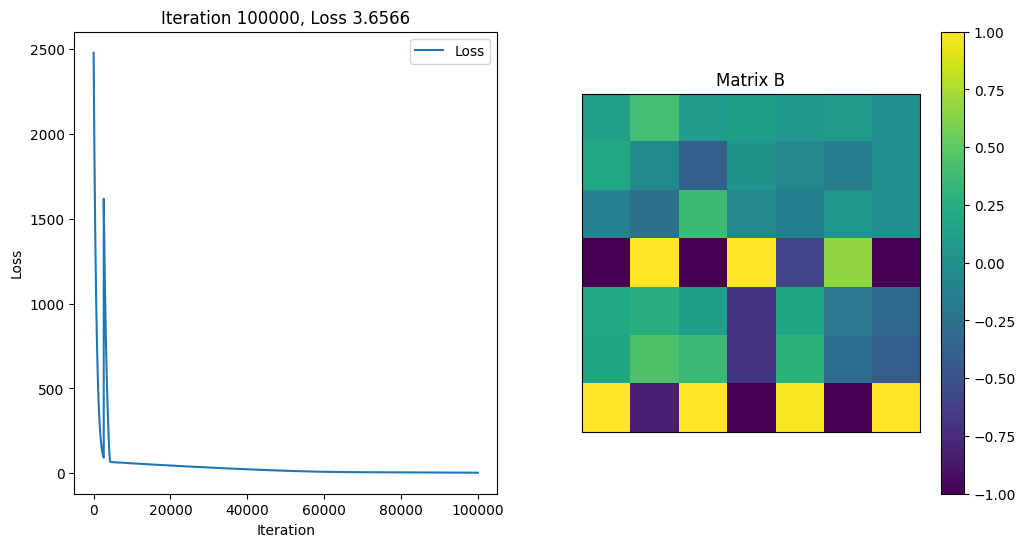

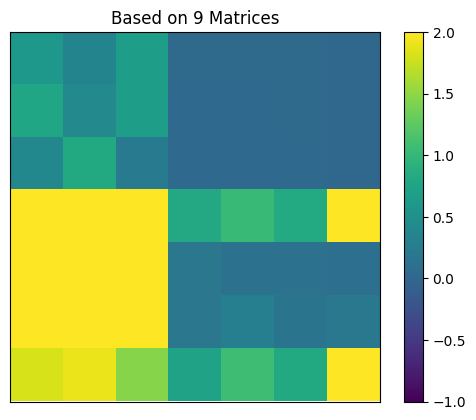

In [ ]:
# Number of sims
N = 10
learning_rate = 4e-4
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((), ())
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(c_helm, N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

From this set b[1,4:7]=0, b[2,4:7]=0, b[3,4:7]=0, b[5,5:7]=0, b[6,6]=0

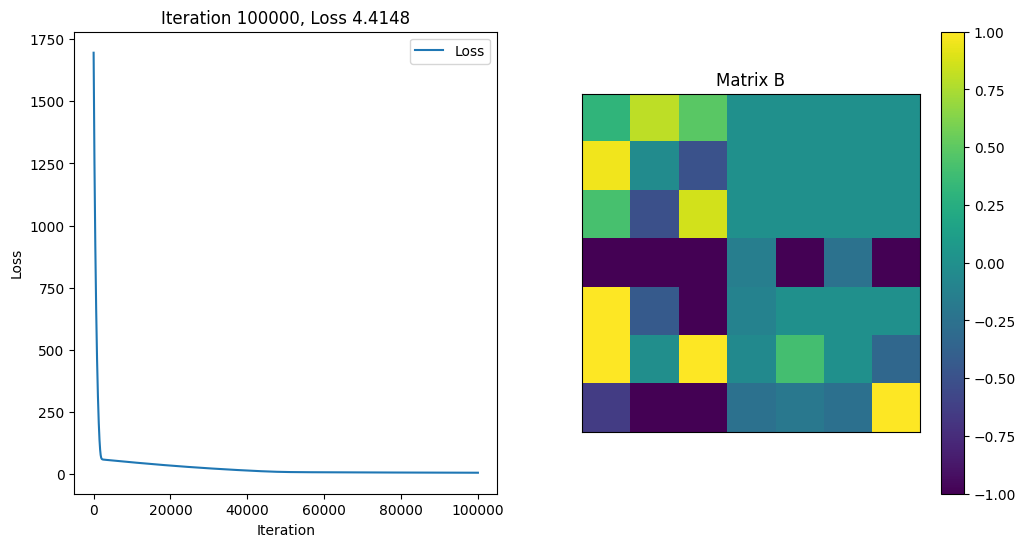

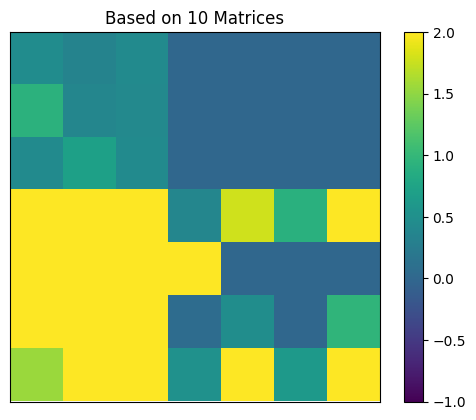

In [ ]:
# Number of sims
N = 10
learning_rate = 4e-4
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,0,1,1,1,1,2,2,2,2,4,4,4,5), (3,4,5,6,3,4,5,6,3,4,5,6,4,5,6,5))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(c_helm, N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

b[6,4] = 0

## Assumption: b[4,6] !=0
Set b[4,2]=0 using m1

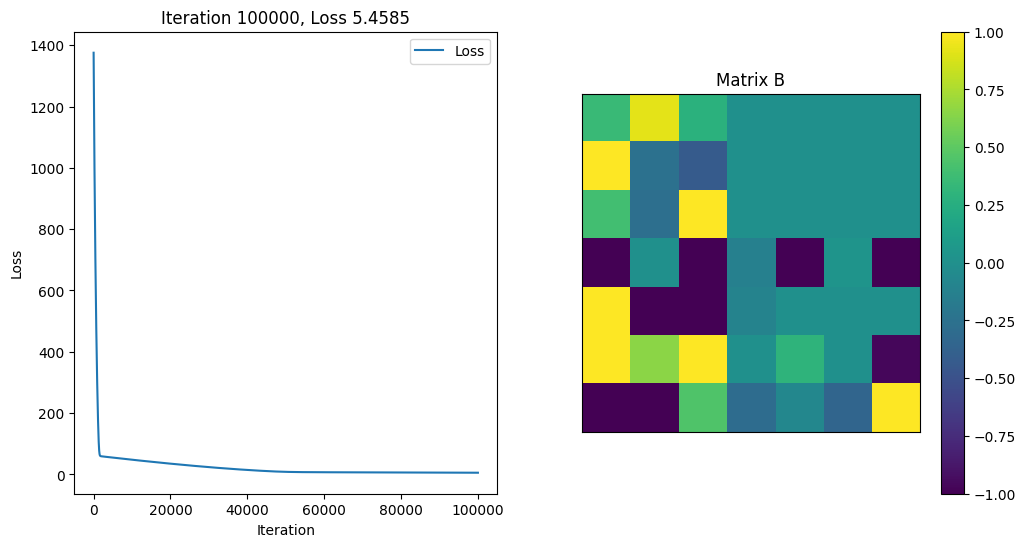

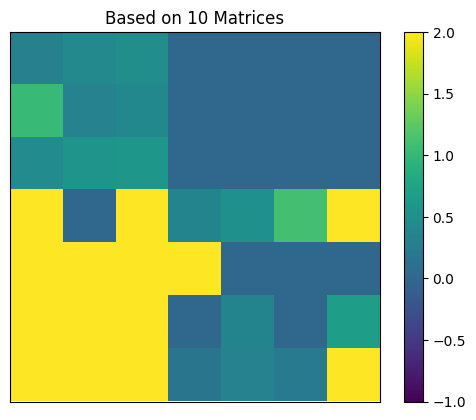

In [ ]:
# Number of sims
N = 10
learning_rate = 4e-4
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,0,1,1,1,1,2,2,2,2,4,4,4,5,5,3), (3,4,5,6,3,4,5,6,3,4,5,6,4,5,6,5,3,1))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(c_helm, N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

# Helmholtz with cutoff ADAM

In [ ]:
# 7 generators, order
N_gen = 7

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_helm = jnp.zeros((N_gen,N_gen,N_gen))

# Commutator values from commutation table [row, column, result, structure constant value]
# Can also be read as [gen_1, gen_2, result_gen, structure constant value]
commutation_relations = [[1,5,3,-1],[1,6,2,1],
                         [2,4,3,1],[2,6,1,-1],
                         [3,4,2,-1],[3,5,1,1],
                         [4,5,6,-1],[4,6,5,1],
                         [5,6,4,-1]]

c_helm = comms_to_matrix(commutation_relations, N_gen)
#print(c_helm)

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(c, N, l_rate, iters, const_pos, const_vals):
  cutoff = 1

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices, values):
    B = B.at[indices].set(values)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c,B,B)
    rhs = jnp.einsum("jik,kn->nij",c,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = 10*random.normal(key, (N_gen,N_gen))

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, const_pos, const_vals)
    print(B)

    loss_values = []

    # Use ADAM Solver
    solver = optax.adam(l_rate)
    params = B_init
    opt_state = solver.init(params)

    for iter in range(iters):
      grad_adam = grad_loss(params)
      updates, opt_state = solver.update(grad_adam, opt_state, params)

      params = optax.apply_updates(params, updates)
      params = keep_constant(params, const_pos, const_vals)

      param_loss = loss(params)
      loss_values.append(loss(params))

      if param_loss < cutoff:
        break

    clear_output(wait=True)

    # calculate parameters for plotting and returning output
    B = params
    current_loss = loss(B)

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Iteration {idx+1}, Loss {current_loss:.4f}')

    # Showing the matrix B
    plt.subplot(1, 2, 2)
    plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('Matrix B')
    plt.xticks([])
    plt.yticks([])

    display(plt.gcf())
    plt.close()

    if current_loss < cutoff*2:
      B_list[idx] = B
    else:
      zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

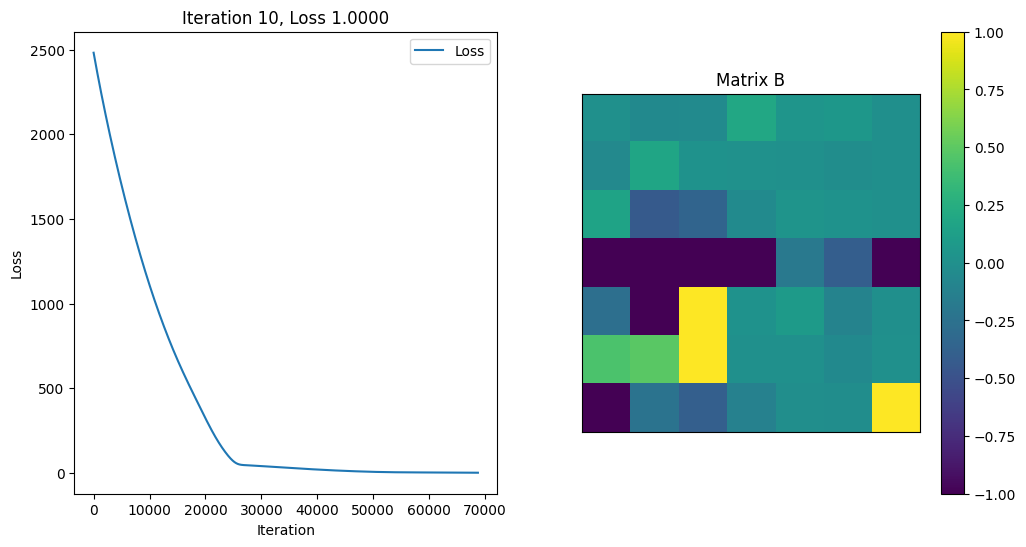

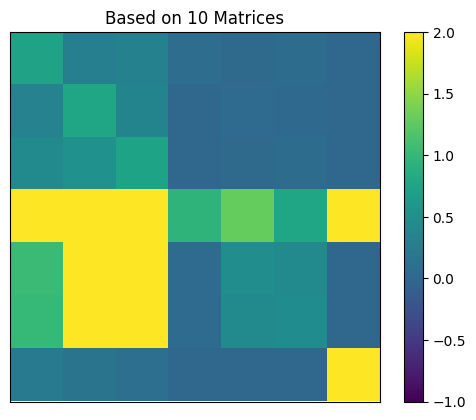

In [ ]:
# Number of sims
N = 10
learning_rate = 4e-4
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((), ())
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(c_helm, N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Gives b[1,4:7]=0, b[2,4:7]=0, b[3,4:7]=0, b[5,4&7]=0, b[6,4&7]=0, b[7,4:6]=0 <br>
This means b[4,4] != 0, set b[4,3]=0 using matrix 2


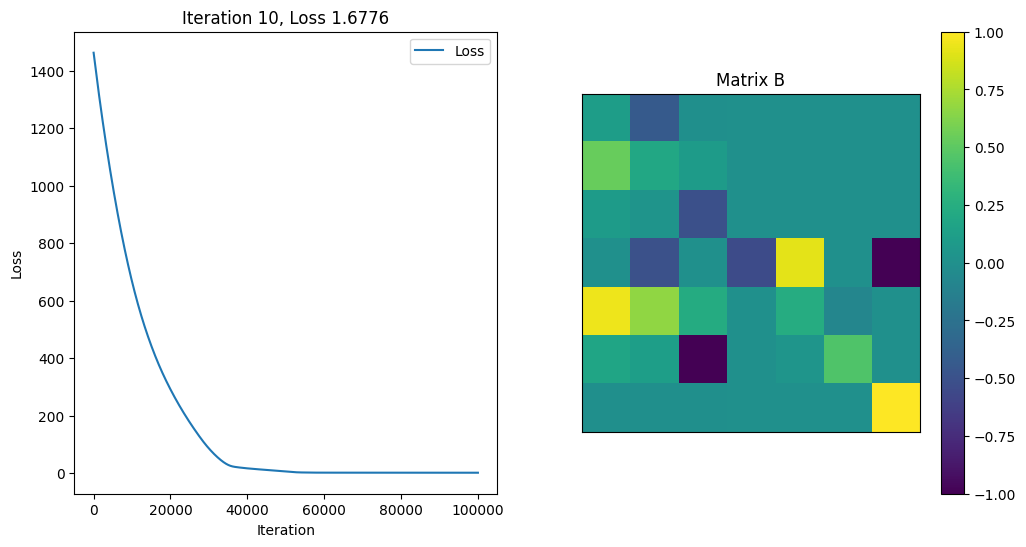

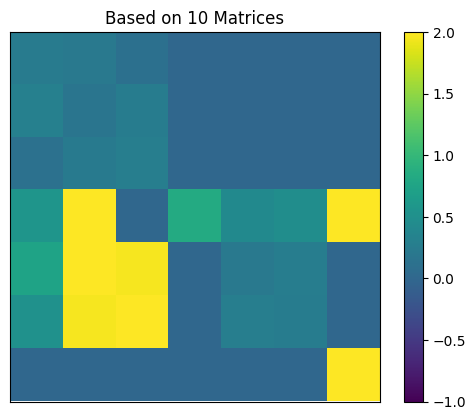

In [ ]:
# Number of sims
N = 10
learning_rate = 4e-4
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,0,1,1,1,1,2,2,2,2,4,4,5,5,6,6,6,3), (3,4,5,6,3,4,5,6,3,4,5,6,3,6,3,6,3,4,5,2))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(c_helm, N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Gives b[7,1:3]=0 <br>
Set b[4,2]=0 using matrix 3

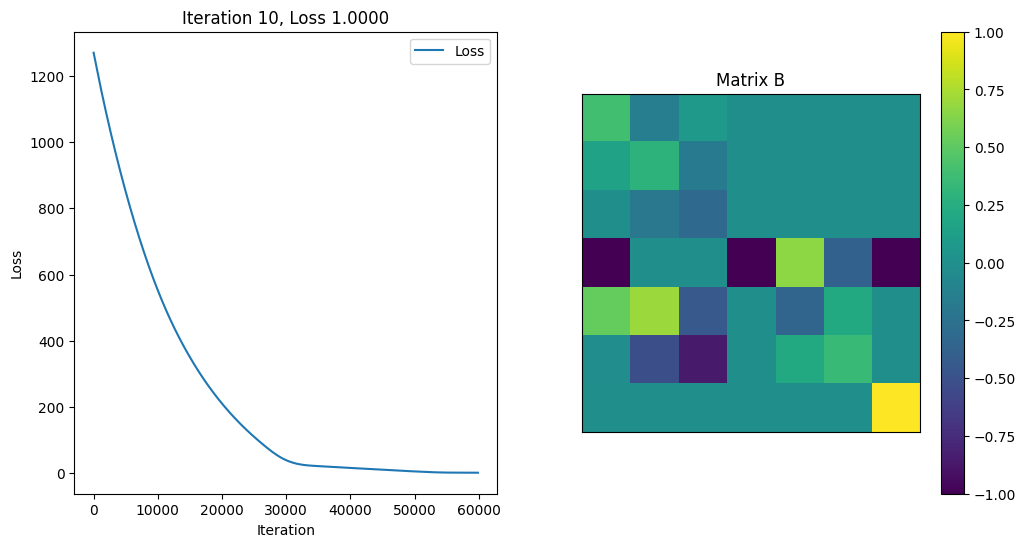

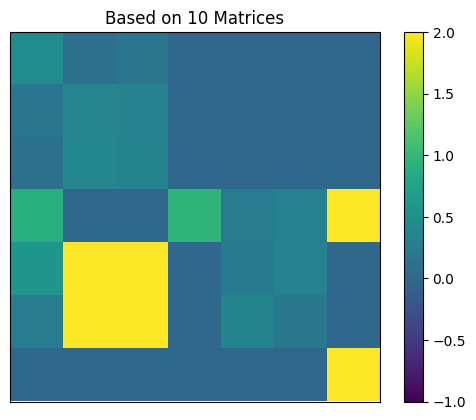

In [ ]:
# Number of sims
N = 10
learning_rate = 4e-4
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,0,1,1,1,1,2,2,2,2,4,4,5,5,6,6,6,3,6,6,6,3), (3,4,5,6,3,4,5,6,3,4,5,6,3,6,3,6,3,4,5,2,0,1,2,1))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(c_helm, N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

No new info

## Assumption: b[6,5] !=0
looks to be the case from the previous figure

Set b[6,3] = 0 using matrix 1

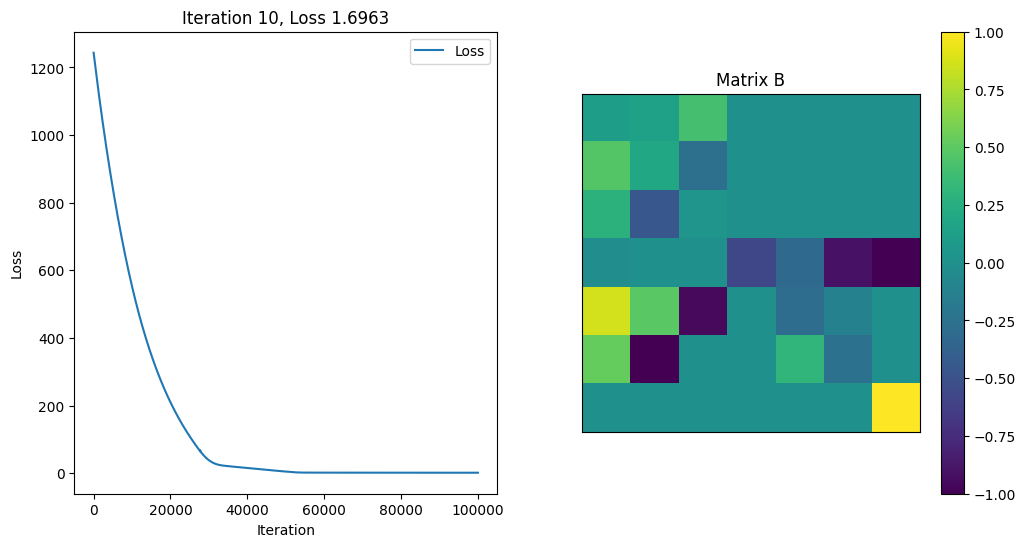

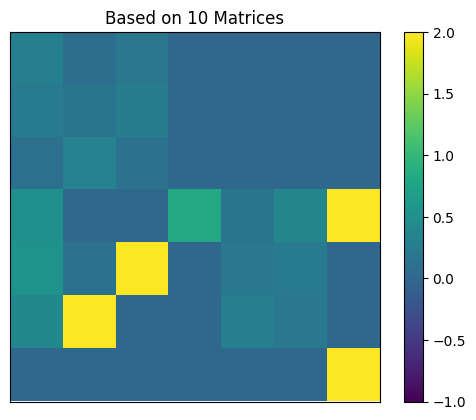

In [ ]:
# Number of sims
N = 10
learning_rate = 4e-4
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,0,1,1,1,1,2,2,2,2,4,4,5,5,6,6,6,3,6,6,6,3,5), (3,4,5,6,3,4,5,6,3,4,5,6,3,6,3,6,3,4,5,2,0,1,2,1,2))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(c_helm, N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Gives nothing new <br>
Set b[6,2]=0 using m4

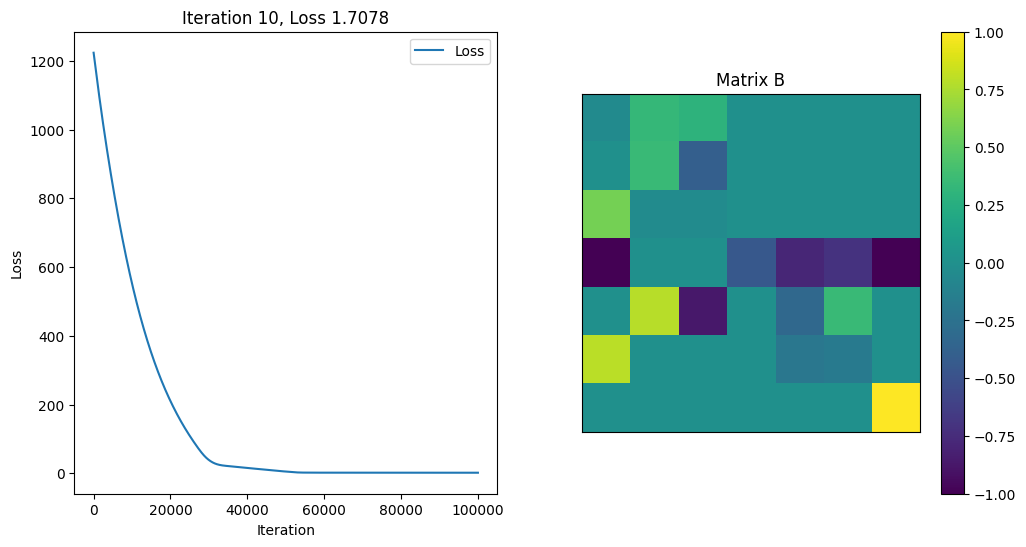

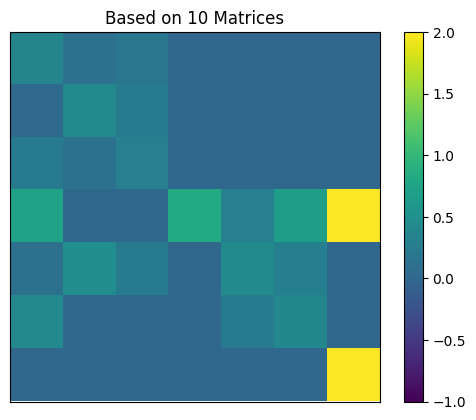

In [ ]:
# Number of sims
N = 10
learning_rate = 4e-4
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,0,1,1,1,1,2,2,2,2,4,4,5,5,6,6,6,3,6,6,6,3,5,5), (3,4,5,6,3,4,5,6,3,4,5,6,3,6,3,6,3,4,5,2,0,1,2,1,2,1))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(c_helm, N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

# Laplace Equation

Put in the structure constants <br>
Order: $P_i, J_i, S, K_i, D$ <br>
I.e. $\mathbf{v_{1,2,3}} = P_{1,2,3}$ and $\mathbf{v_{4,5,6}} = J_{1,2,3}$ and $\mathbf{v_7}=S$ and $\mathbf{v_{8,9,10}}=K_{1,2,3}$ and $\mathbf{v_{11}}=D$

In [ ]:
# 11 generators, order
N_gen = 11

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_lapl = jnp.zeros((N_gen,N_gen,N_gen))

# Commutator values from commutation table [row, column, result, structure constant value]
# Can also be read as [gen_1, gen_2, result_gen, structure constant value]
commutation_relations = [[1,5,3,-1],[1,6,2,1],  # |  [P_1, J_i]
                         [2,4,3,1],[2,6,1,-1],  # |  [P_2, J_i]
                         [3,4,2,-1],[3,5,1,1],  # |  [P_3, J_i]
                         [4,5,6,-1],[4,6,5,1],  # |  [J_1, J_i]
                         [5,6,4,-1],            # |  [J_2, J_3]          same structure constants as helmholtz
                         [11,1,1,-1],[11,2,2,-1],[11,3,3,-1],    # [D, P_i]
                         [11,8,8,1],[11,9,9,1],[11,10,10,1],     # [D, J_i]
                         [1,8,7,-1],[1,8,11,2],[1,9,6,-2],[1,10,5,2],  # [P_1, K_i]
                         [2,8,6,2],[2,9,7,-1],[2,9,11,2],[2,10,4,-2],  # [P_2, K_i]
                         [3,8,5,-2],[3,9,4,2],[3,10,7,-1],[3,10,11,2], # [P_3, K_i]
                         [4,9,10,-1],[4,10,9,1],[5,8,10,1],[5,10,8,-1],[6,8,9,-1],[6,9,8,1]]  #[K_i, K_j]

c_lapl = comms_to_matrix(commutation_relations, N_gen)
print(c_lapl)

[[[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [-1.  0.  0. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0. -2.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0. -1.  0. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0. -2.]
  [ 0.  0. -1. ...  0.  0.  0.]]

 ...

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  2.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  1.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  2.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  1.  

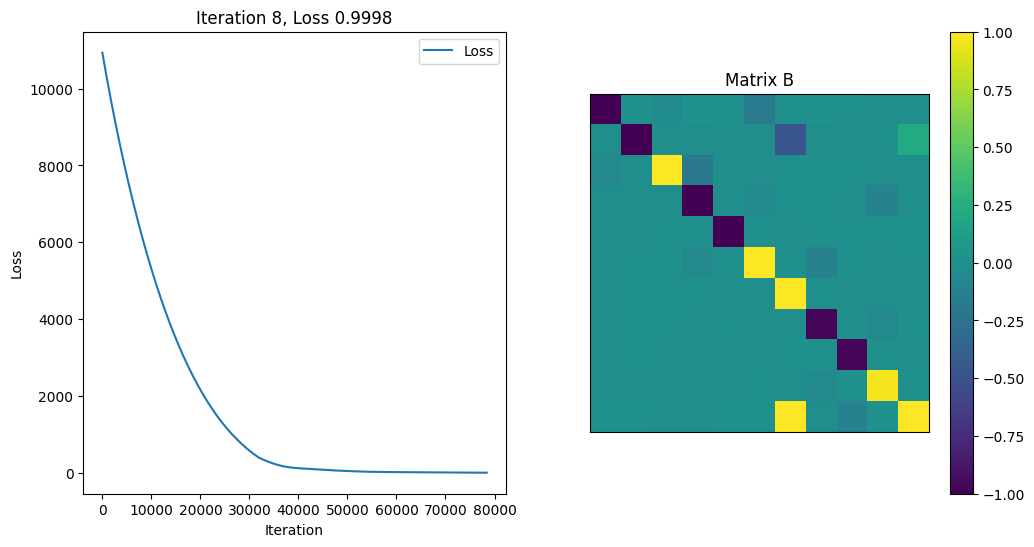

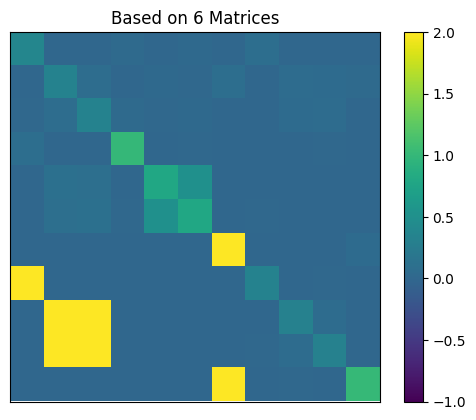

In [ ]:
# Number of sims
N = 8
learning_rate = 4e-4
iterations = 120_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((), ())
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(c_lapl, N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

# Laplace Equation (Jitted Adam Unif)

In [ ]:
# 11 generators, order
N_gen = 11

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_lapl = jnp.zeros((N_gen,N_gen,N_gen))

# Commutator values from commutation table [row, column, result, structure constant value]
# Can also be read as [gen_1, gen_2, result_gen, structure constant value]
commutation_relations = [[1,5,3,-1],[1,6,2,1],  # |  [P_1, J_i]
                         [2,4,3,1],[2,6,1,-1],  # |  [P_2, J_i]
                         [3,4,2,-1],[3,5,1,1],  # |  [P_3, J_i]
                         [4,5,6,-1],[4,6,5,1],  # |  [J_1, J_i]
                         [5,6,4,-1],            # |  [J_2, J_3]          same structure constants as helmholtz
                         [11,1,1,-1],[11,2,2,-1],[11,3,3,-1],    # [D, P_i]
                         [11,8,8,1],[11,9,9,1],[11,10,10,1],     # [D, J_i]
                         [1,8,7,-1],[1,8,11,2],[1,9,6,-2],[1,10,5,2],  # [P_1, K_i]
                         [2,8,6,2],[2,9,7,-1],[2,9,11,2],[2,10,4,-2],  # [P_2, K_i]
                         [3,8,5,-2],[3,9,4,2],[3,10,7,-1],[3,10,11,2], # [P_3, K_i]
                         [4,9,10,-1],[4,10,9,1],[5,8,10,1],[5,10,8,-1],[6,8,9,-1],[6,9,8,1]]  #[K_i, K_j]

c_lapl = comms_to_matrix(commutation_relations, N_gen)

# Uncomment to print out commutation matrices
#with np.printoptions(threshold=np.inf):
#    print(c_lapl)

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals, solver=None):

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_lapl,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_lapl,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  @jit
  def updater(params, opt_state):
    grad_adam = grad_loss(params)
    updates, opt_state = solver.update(grad_adam, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = random.uniform(key, shape=(N_gen,N_gen),minval=-2, maxval=2)

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    # Use ADAM Solver
    solver = optax.adam(l_rate)
    params = B_init
    opt_state = solver.init(params)

    for iter in range(iterations):
      grad_adam = grad_loss(params)

      params, opt_state = updater(params, opt_state)
      params = keep_constant(params, zero_list)

      param_loss = loss(params)
      loss_values.append(loss(params))

      #if param_loss < cutoff:
      #  break


    clear_output(wait=True)

    # Use final result as B matrix
    B = params
    last_loss = loss(B)
    print(last_loss)

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Iteration {len(loss_values)}, Loss {last_loss:.4f}')

    # Showing the matrix B
    plt.subplot(1, 2, 2)
    plt.imshow(B, cmap='viridis', vmin=-1, vmax=2)
    plt.colorbar()
    plt.title('Matrix B')
    plt.xticks([])
    plt.yticks([])

    display(plt.gcf())
    plt.close()

    if last_loss < 0.1:
      B_list[idx] = B
    else:
      zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

0.006419593


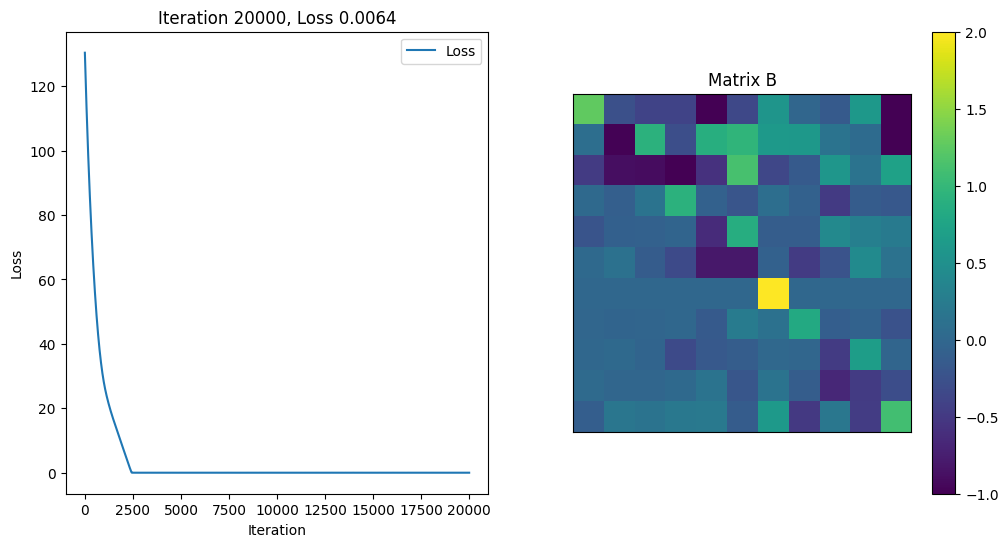

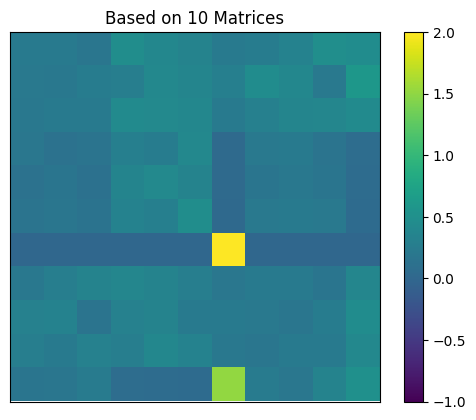

In [ ]:
# Number of sims
N = 20
learning_rate = 1e-3
iterations = 20_000

# Tuple of rows and columns of each known zero entry
zero_list = ((), ())
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

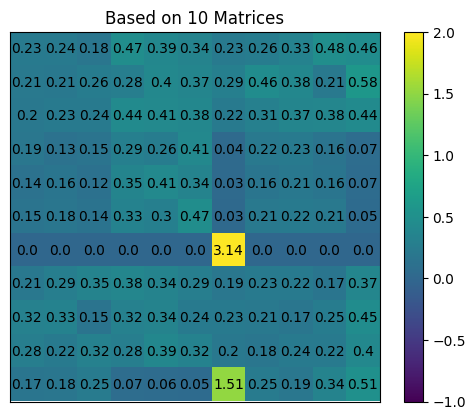

In [ ]:
matrix_plotter(B_sum, zero_determinant_counter, values=True)

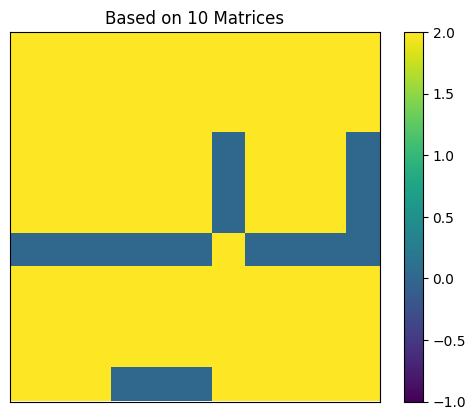

In [ ]:
zero_highlighter(B_sum, 0.1, zero_determinant_counter)

In [ ]:
zero_indices = give_zero_indices(B_sum, 0.1, [])
print(zero_indices)

New indices: 
B[[4, 7]]=0;
B[[4, 11]]=0;
B[[5, 7]]=0;
B[[5, 11]]=0;
B[[6, 7]]=0;
B[[6, 11]]=0;
B[[7, 1]]=0;
B[[7, 2]]=0;
B[[7, 3]]=0;
B[[7, 4]]=0;
B[[7, 5]]=0;
B[[7, 6]]=0;
B[[7, 8]]=0;
B[[7, 9]]=0;
B[[7, 10]]=0;
B[[7, 11]]=0;
B[[11, 4]]=0;
B[[11, 5]]=0;
B[[11, 6]]=0;
[[4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [11, 4], [11, 5], [11, 6]]


Try again, new zero indices?

2.6990528


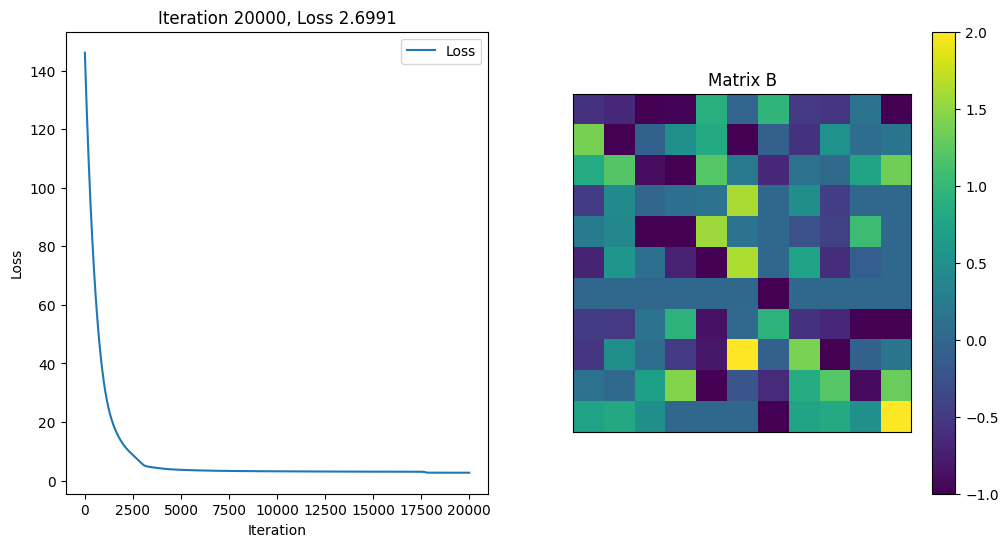

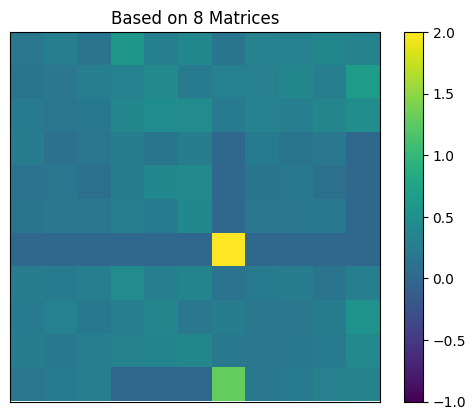

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 20_000

# indices of all zero b values
zero_indices = [[4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [11, 4], [11, 5], [11, 6]]

# Tuple of rows and columns of each known zero entry
zero_list = convert_indices_zerolist(zero_indices)
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
zero_indices_new = give_zero_indices(B_sum, 0.05, zero_indices)

New indices: 


In [ ]:
print(zero_indices_new)

[[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 9], [1, 10], [1, 11], [2, 1], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 11], [3, 1], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 11], [4, 1], [4, 2], [4, 3], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 4], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 4], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 9], [8, 10], [8, 11], [9, 1], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 11], [10, 1], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10]]


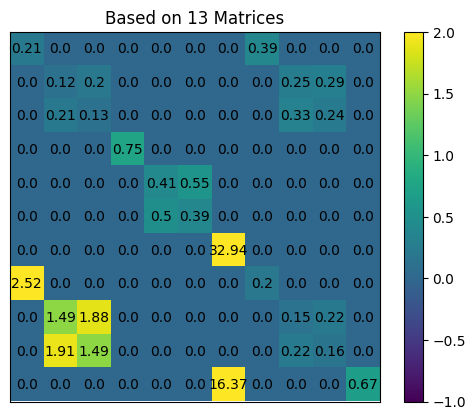

In [ ]:
matrix_plotter(B_sum, zero_determinant_counter, values=True)

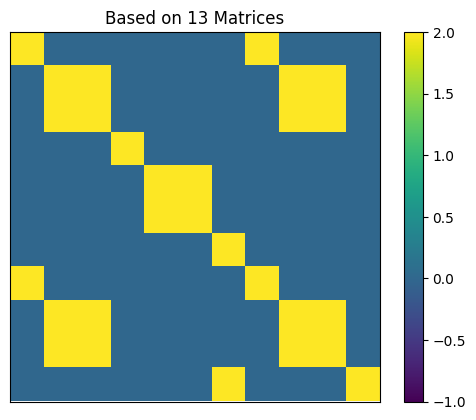

In [ ]:
zero_highlighter(B_sum, 0.05, zero_determinant_counter)

In [ ]:
# Final zero indices, use for both
[[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 9], [1, 10], [1, 11], [2, 1], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 11], [3, 1], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 11], [4, 1], [4, 2], [4, 3], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 4], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 4], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 9], [8, 10], [8, 11], [9, 1], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 11], [10, 1], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10]]

## Assumption: b[1,1]!=0 (sets b[8,1]=0 using m1)


4.7098217


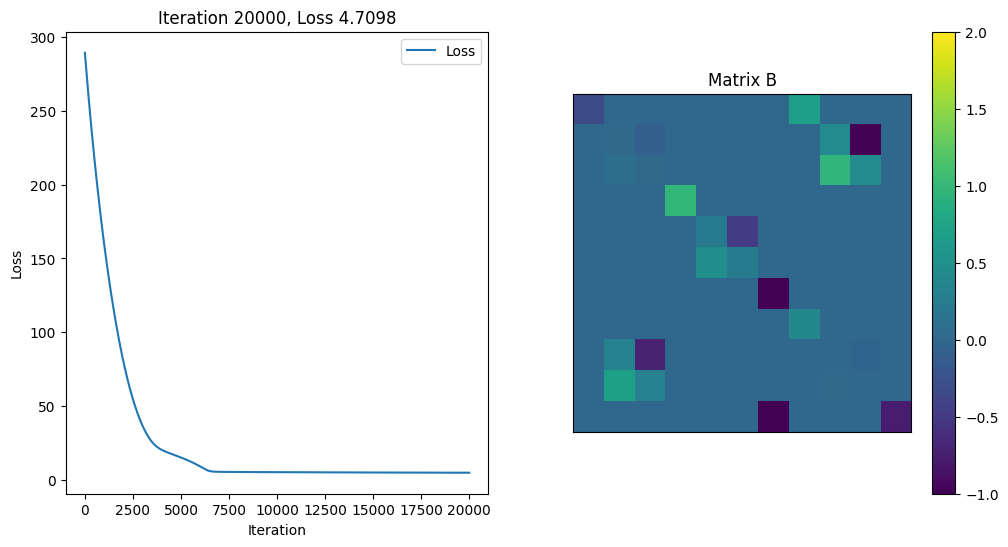

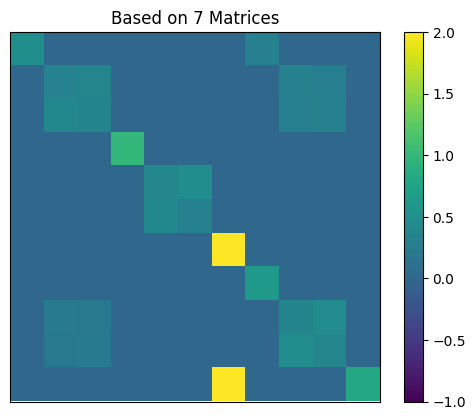

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 20_000

# indices of all zero b values
zero_indices = [[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 9], [1, 10], [1, 11], [2, 1], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 11], [3, 1], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 11], [4, 1], [4, 2], [4, 3], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 4], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 4], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 9], [8, 10], [8, 11], [9, 1], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 11], [10, 1], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10], [8,1]]

# Tuple of rows and columns of each known zero entry
zero_list = convert_indices_zerolist(zero_indices)
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
zero_indices_new = give_zero_indices(B_sum, 0.05, zero_indices)

Set b[1,8]=0 using M8 and b[8,8]!=0 (requires complex eps)

5.27538


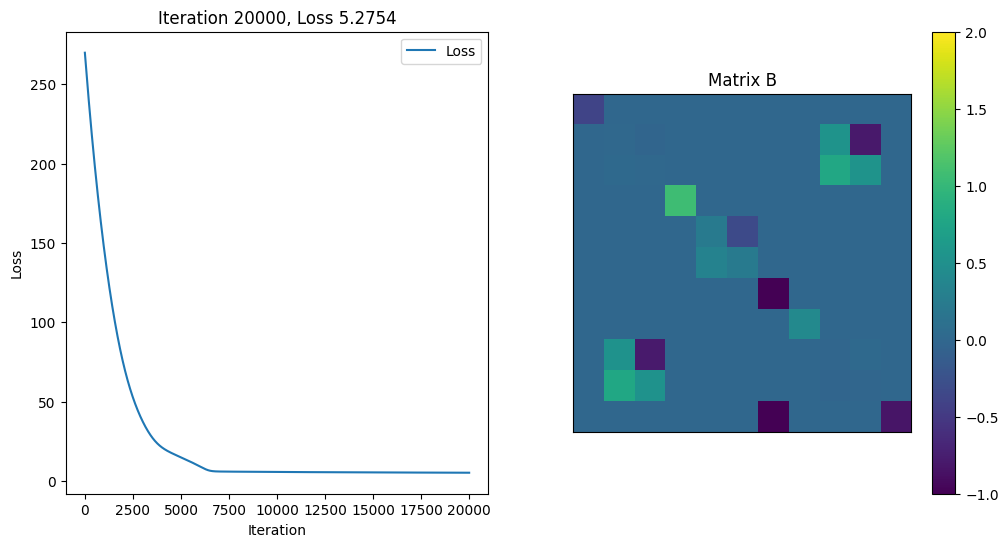

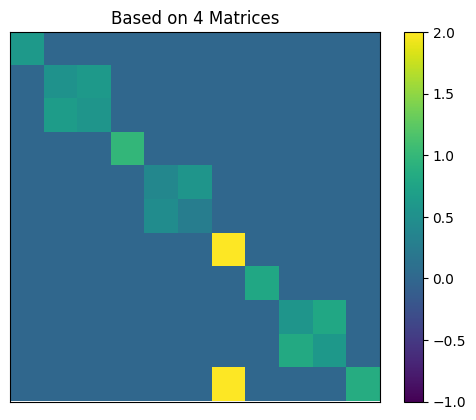

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 20_000

# indices of all zero b values
zero_indices = [[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 9], [1, 10], [1, 11], [2, 1], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 11], [3, 1], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 11], [4, 1], [4, 2], [4, 3], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 4], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 4], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 9], [8, 10], [8, 11], [9, 1], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 11], [10, 1], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10], [8,1], [1,8]]

# Tuple of rows and columns of each known zero entry
zero_list = convert_indices_zerolist(zero_indices)
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Further matrices cannot be used to eliminate another variable, apply nonl conditions?

## Assumption: b[1,1]=0 (do not use M1)

1.415359


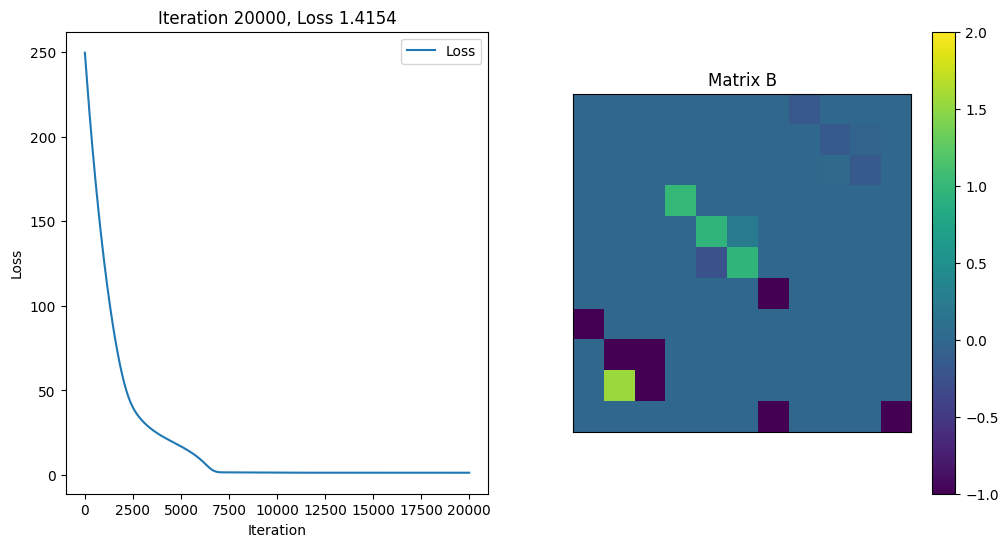

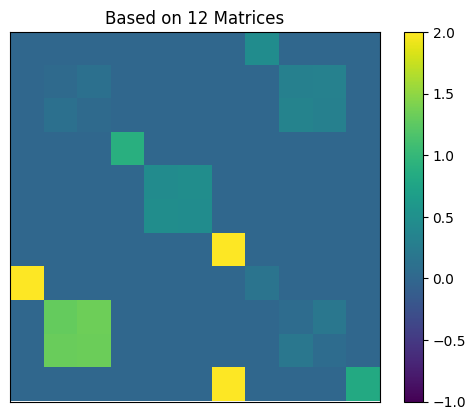

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 20_000

# indices of all zero b values
zero_indices = [[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 9], [1, 10], [1, 11], [2, 1], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 11], [3, 1], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 11], [4, 1], [4, 2], [4, 3], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 4], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 4], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 9], [8, 10], [8, 11], [9, 1], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 11], [10, 1], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10], [1,1]]

# Tuple of rows and columns of each known zero entry
zero_list = convert_indices_zerolist(zero_indices)
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
zero_indices_new = give_zero_indices(B_sum, 0.05, zero_indices)

New indices: 
B[[2, 2]]=0;
B[[3, 3]]=0;


In [ ]:
print(zero_indices_new)

[[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 9], [1, 10], [1, 11], [2, 1], [2, 2], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 11], [3, 1], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 11], [4, 1], [4, 2], [4, 3], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 4], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 4], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 9], [8, 10], [8, 11], [9, 1], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 11], [10, 1], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10]]


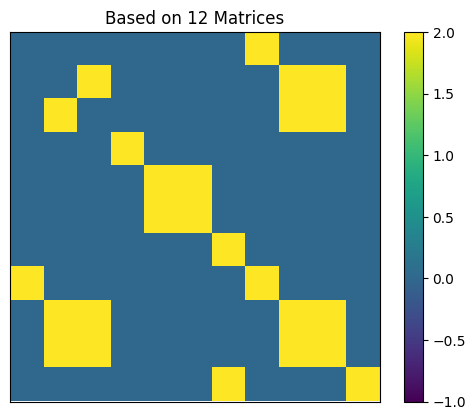

In [ ]:
zero_highlighter(B_sum, 0.05, zero_determinant_counter)

Sets b[2,2]=b[3,3]=0

Set b[8,8]=0 using M2 and b[1,8]!=0

1.4159582


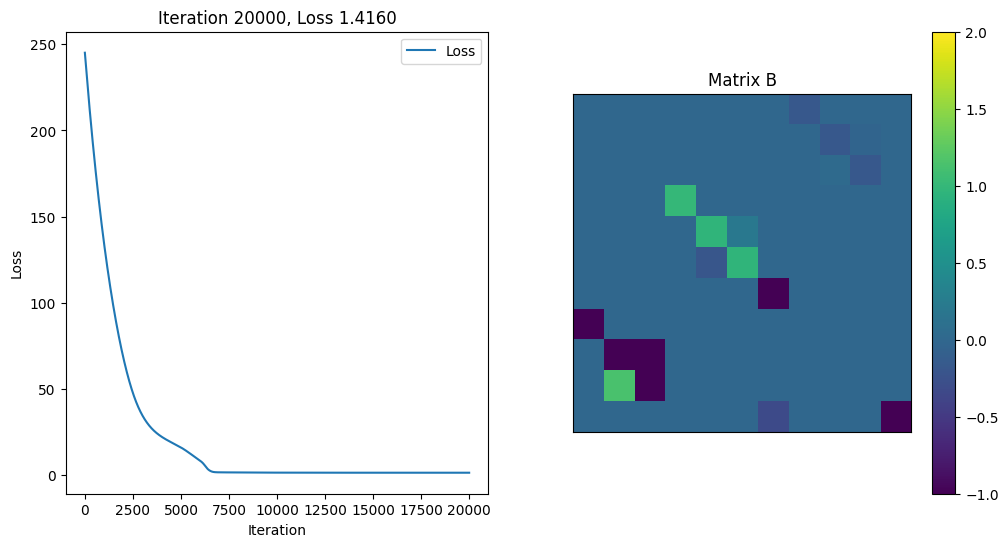

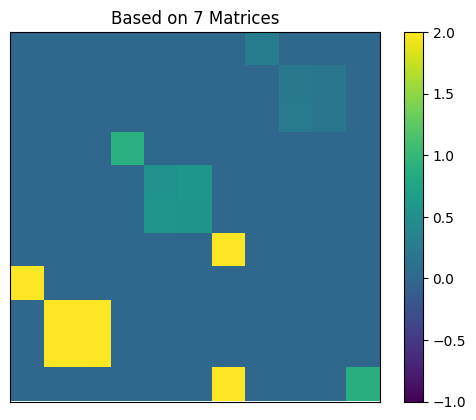

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 20_000

# indices of all zero b values
zero_indices = [[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 9], [1, 10], [1, 11], [2, 1], [2, 2], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 11], [3, 1], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 11], [4, 1], [4, 2], [4, 3], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 4], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 4], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 9], [8, 10], [8, 11], [9, 1], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 11], [10, 1], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10], [8,8]]

# Tuple of rows and columns of each known zero entry
zero_list = convert_indices_zerolist(zero_indices)
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

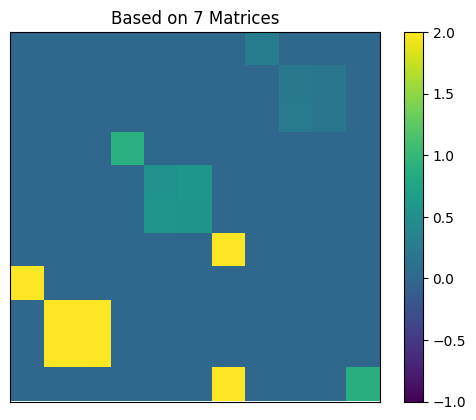

In [ ]:
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
#plt.savefig("lapl-adj2(b1,1=0)-adam-cutoff5-n25-l1e3-i20_000.pdf",bbox_inches='tight')
plt.savefig("lapl-adj2(b1,1=0)-adam-cutoff5-n25-l1e3-i20_000.jpg",bbox_inches='tight')
plt.show()

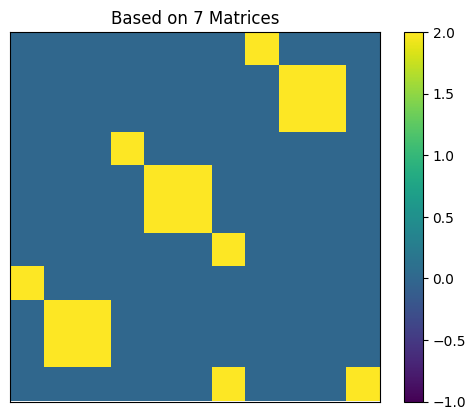

In [ ]:
B_m = np.zeros(np.shape(B_sum))

for (i,j),label in np.ndenumerate(B_sum):
  if label < 0.05:
    B_m[i,j]=0
  else:
    B_m[i,j]=2

plt.imshow(B_m, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])

#plt.savefig("lapl-highl0.05-adj2(b1,1=0)-adam-cutoff5-n25-l1e3-i20_000.pdf",bbox_inches='tight')
plt.savefig("lapl-highl0.05-adj2(b1,1=0)-adam-cutoff5-n25-l1e3-i20_000.jpg",bbox_inches='tight')
plt.show()

In [ ]:
zero_indices_new = give_zero_indices(B_sum, 0.05, zero_indices)
print(zero_indices_new)

New indices: 
B[[2, 3]]=0;
B[[3, 2]]=0;
B[[9, 9]]=0;
B[[9, 10]]=0;
B[[10, 9]]=0;
B[[10, 10]]=0;
[[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 9], [1, 10], [1, 11], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 11], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 11], [4, 1], [4, 2], [4, 3], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 4], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 4], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 8], [8, 9], [8, 10], [8, 11], [9, 1], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9], [9, 10], [9, 11], [10, 1], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 9], [10, 10], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10]]


In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 20_000

# indices of all zero b values
zero_indices = [[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 9], [1, 10], [1, 11], [2, 1], [2, 2], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 11], [3, 1], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 11], [4, 1], [4, 2], [4, 3], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 4], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 4], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 9], [8, 10], [8, 11], [9, 1], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 11], [10, 1], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10], [8,8]]

# Tuple of rows and columns of each known zero entry
zero_list = convert_indices_zerolist(zero_indices)
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

# Laplace Equation Na Edit Struc Const

In [ ]:
# 11 generators, order
N_gen = 11

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_lapl = jnp.zeros((N_gen,N_gen,N_gen))

# Commutator values from commutation table [row, column, result, structure constant value]
# Can also be read as [gen_1, gen_2, result_gen, structure constant value]
commutation_relations = [[1,5,3,-1],[1,6,2,1],  # |  [P_1, J_i]
                         [2,4,3,1],[2,6,1,-1],  # |  [P_2, J_i]
                         [3,4,2,-1],[3,5,1,1],  # |  [P_3, J_i]
                         [4,5,6,-1],[4,6,5,1],  # |  [J_1, J_i]
                         [5,6,4,-1],            # |  [J_2, J_3]          same structure constants as helmholtz
                         [11,1,1,-1],[11,2,2,-1],[11,3,3,-1],    # [D, P_i]
                         [11,8,8,1],[11,9,9,1],[11,10,10,1],     # [D, J_i]
                         [1,8,7,-1],[1,8,11,2],[1,9,6,-2],[1,10,5,2],  # [P_1, K_i]
                         [2,8,6,2],[2,9,7,-1],[2,9,11,2],[2,10,4,-2],  # [P_2, K_i]
                         [3,8,5,-2],[3,9,4,2],[3,10,7,-1],[3,10,11,2], # [P_3, K_i]
                         [4,9,10,-1],[4,10,9,1],[5,8,10,1],[5,10,8,-1],[6,8,9,-1],[6,9,8,1]]  #[K_i, K_j]

c_lapl = comms_to_matrix(commutation_relations, N_gen)

# Uncomment to print out commutation matrices
#with np.printoptions(threshold=np.inf):
#    print(c_lapl)

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals, solver=None):

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_lapl,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_lapl,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  @jit
  def updater(params, opt_state):
    grad_adam = grad_loss(params)
    updates, opt_state = solver.update(grad_adam, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = random.uniform(key, shape=(N_gen,N_gen),minval=-2, maxval=2)

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    # Use ADAM Solver
    solver = optax.adam(l_rate)
    params = B_init
    opt_state = solver.init(params)

    for iter in range(iterations):
      grad_adam = grad_loss(params)

      params, opt_state = updater(params, opt_state)
      params = keep_constant(params, zero_list)

      param_loss = loss(params)
      loss_values.append(loss(params))

      #if param_loss < cutoff:
      #  break


    clear_output(wait=True)

    # Use final result as B matrix
    B = params
    last_loss = loss(B)
    print(last_loss)

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Iteration {len(loss_values)}, Loss {last_loss:.4f}')

    # Showing the matrix B
    plt.subplot(1, 2, 2)
    plt.imshow(B, cmap='viridis', vmin=-1, vmax=2)
    plt.colorbar()
    plt.title('Matrix B')
    plt.xticks([])
    plt.yticks([])

    display(plt.gcf())
    plt.close()

    if last_loss < 1:
      B_list[idx] = B
    else:
      zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

First run without information

In [ ]:
N = 30
learning_rate = 6e-4
iterations = 20_000

2.5896375


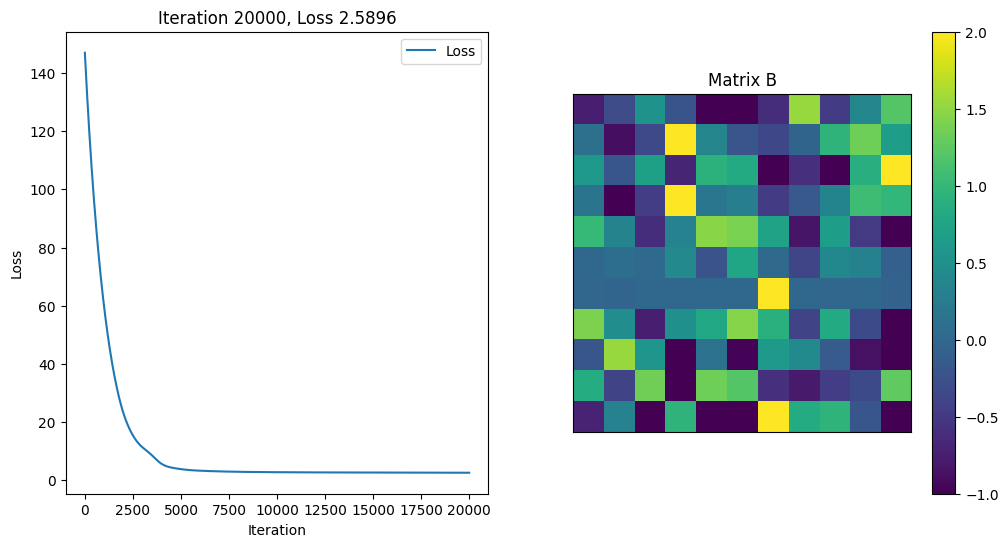

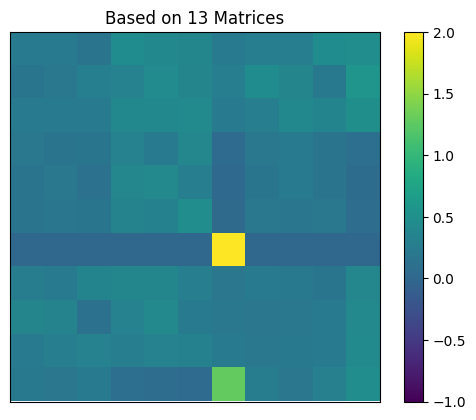

In [ ]:
# Tuple of rows and columns of each known zero entry
zero_list = ((),())
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

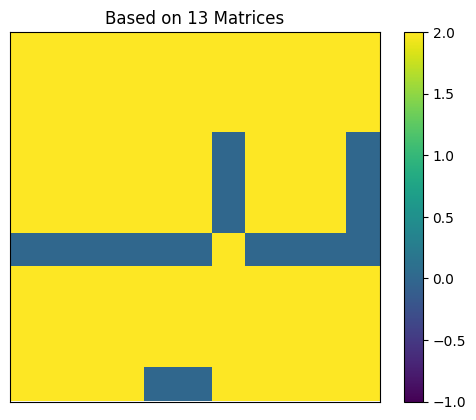

In [ ]:
zero_highlighter(B_sum, 0.1, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, ())
print(new_zero_indices)

New indices: 
B[[4, 7]]=0;
B[[4, 11]]=0;
B[[5, 7]]=0;
B[[5, 11]]=0;
B[[6, 7]]=0;
B[[6, 11]]=0;
B[[7, 1]]=0;
B[[7, 2]]=0;
B[[7, 3]]=0;
B[[7, 4]]=0;
B[[7, 5]]=0;
B[[7, 6]]=0;
B[[7, 8]]=0;
B[[7, 9]]=0;
B[[7, 10]]=0;
B[[7, 11]]=0;
B[[11, 5]]=0;
B[[11, 6]]=0;
[[4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [11, 5], [11, 6]]


## Assumption: b[1,1]=0

In [ ]:
zero_indices = [[4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [11, 5], [11, 6], [1,1]]
zero_list = convert_indices_zerolist(zero_indices)

0.002260533


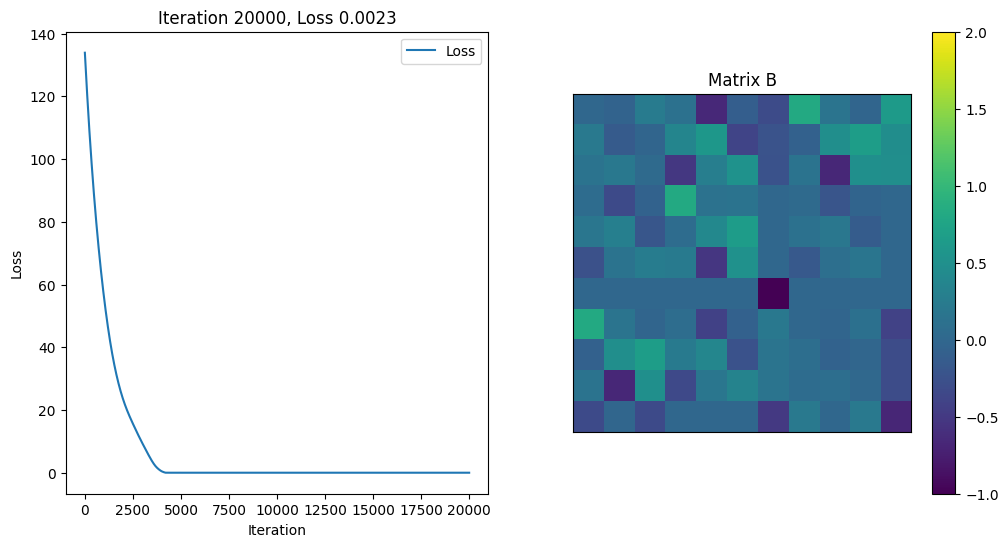

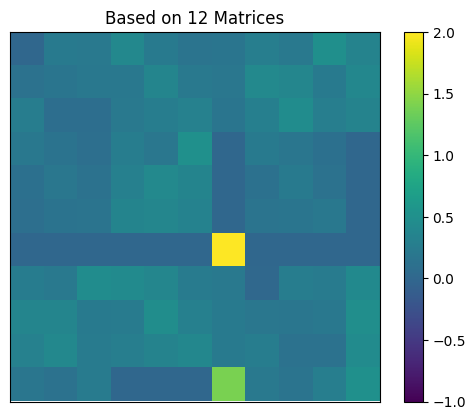

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

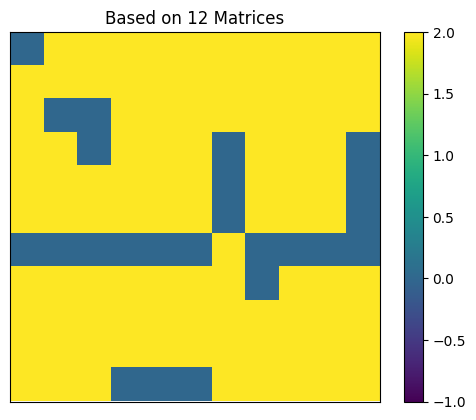

In [ ]:
zero_highlighter(B_sum, 0.1, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[1, 1]]=0;
B[[3, 2]]=0;
B[[3, 3]]=0;
B[[4, 3]]=0;
B[[4, 7]]=0;
B[[4, 11]]=0;
B[[5, 7]]=0;
B[[5, 11]]=0;
B[[6, 7]]=0;
B[[6, 11]]=0;
B[[7, 1]]=0;
B[[7, 2]]=0;
B[[7, 3]]=0;
B[[7, 4]]=0;
B[[7, 5]]=0;
B[[7, 6]]=0;
B[[7, 8]]=0;
B[[7, 9]]=0;
B[[7, 10]]=0;
B[[7, 11]]=0;
B[[8, 8]]=0;
B[[11, 4]]=0;
B[[11, 5]]=0;
B[[11, 6]]=0;
[[1, 1], [3, 2], [3, 3], [4, 3], [4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 8], [11, 4], [11, 5], [11, 6]]


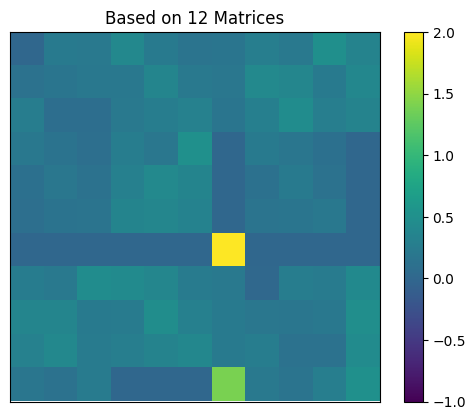

In [ ]:
save_normfig("lapl2-noadj(b11=0)-adam-thresh0.1-cutoff1-n30-l6e4-i20_000")

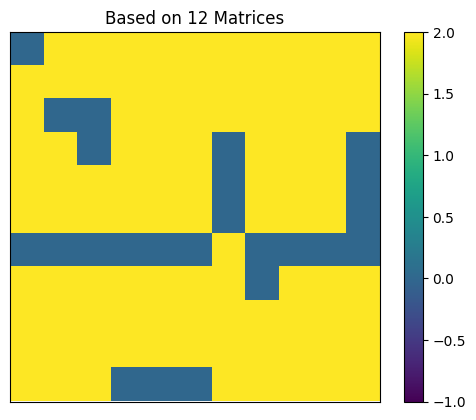

In [ ]:
save_binfig("lapl2-highl0.1-noadj(b11=0)-adam-thresh0.1-cutoff1-n30-l6e4-i20_000", 0.1)

#### Zelfde proberen maar dan alleen [1,1] op 0 zetten.

2.6165047


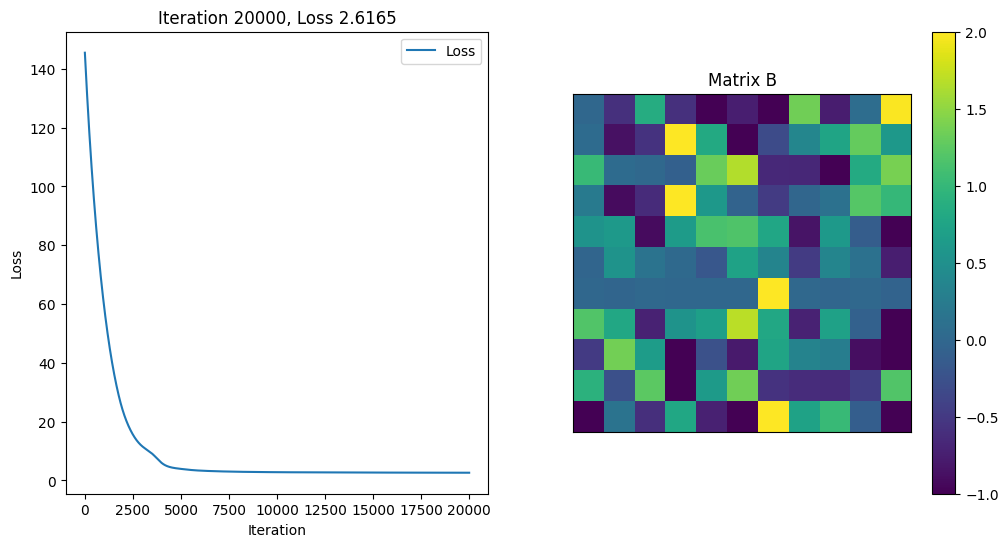

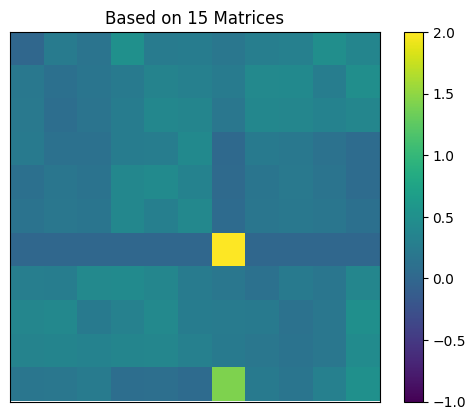

In [ ]:
# Tuple of rows and columns of each known zero entry
zero_list = ((0,0), (0,0))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

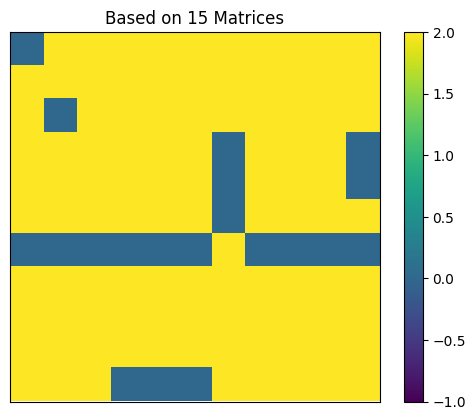

In [ ]:
zero_highlighter(B_sum, 0.1, zero_determinant_counter)

### Assumption: b[8,1] !=0 (sets b[8,11]=0 using m8)

In [ ]:
# previous zeroes plus b[8,11]
zero_indices = [[1, 1], [3, 2], [3, 3], [4, 3], [4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 8], [11, 4], [11, 5], [11, 6], [8,11]]
zero_list = convert_indices_zerolist(zero_indices)

2.7325113


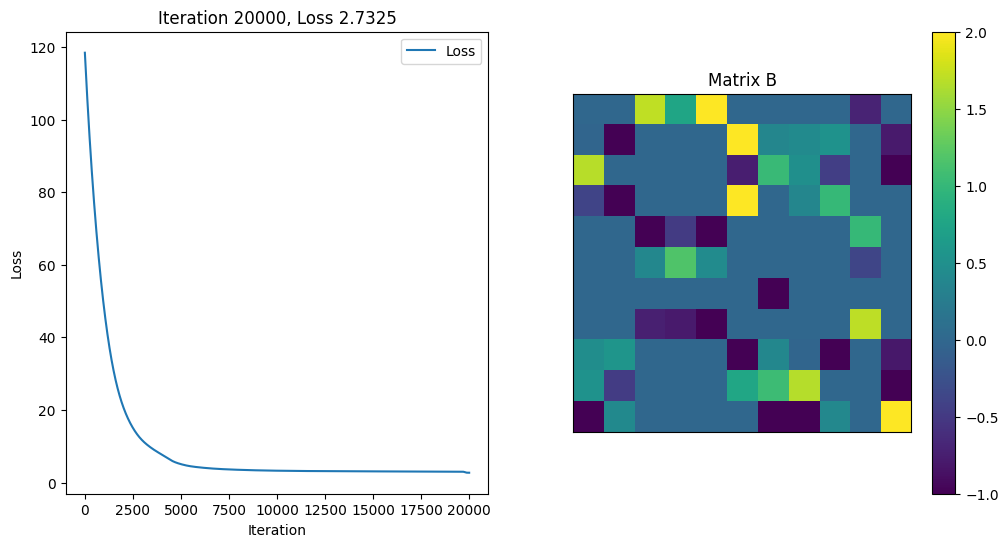

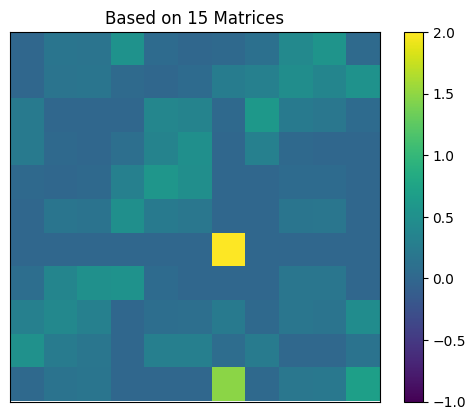

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

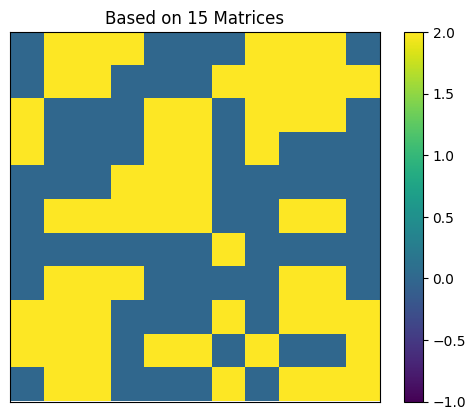

In [ ]:
zero_highlighter(B_sum, 0.1, zero_determinant_counter)

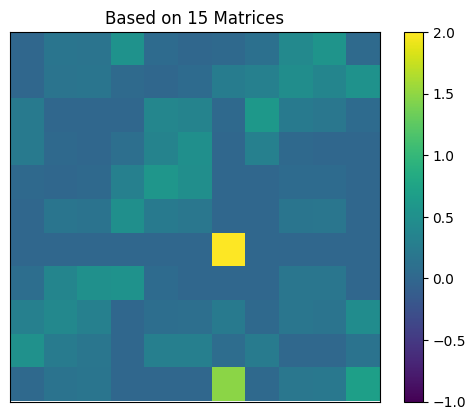

In [ ]:
save_normfig("lapl2-adj8(b11=0)-adam-thresh0.1-cutoff1-n30-l6e4-i20_000")

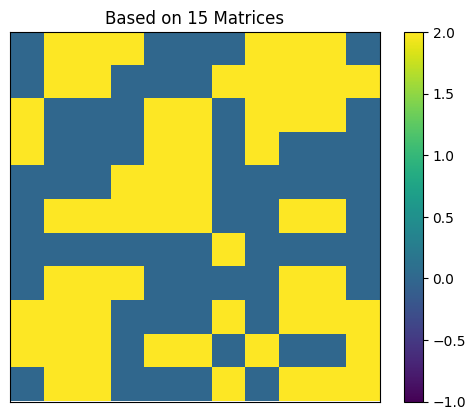

In [ ]:
save_binfig("lapl2-highl0.1-adj8(b11=0)-adam-thresh0.1-cutoff1-n30-l6e4-i20_000", 0.1)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[1, 5]]=0;
B[[1, 6]]=0;
B[[1, 7]]=0;
B[[1, 11]]=0;
B[[2, 1]]=0;
B[[2, 4]]=0;
B[[2, 5]]=0;
B[[2, 6]]=0;
B[[3, 4]]=0;
B[[3, 7]]=0;
B[[3, 11]]=0;
B[[4, 2]]=0;
B[[4, 4]]=0;
B[[4, 9]]=0;
B[[4, 10]]=0;
B[[5, 1]]=0;
B[[5, 2]]=0;
B[[5, 3]]=0;
B[[5, 8]]=0;
B[[5, 9]]=0;
B[[5, 10]]=0;
B[[6, 1]]=0;
B[[6, 8]]=0;
B[[8, 1]]=0;
B[[8, 5]]=0;
B[[8, 6]]=0;
B[[8, 7]]=0;
B[[9, 4]]=0;
B[[9, 5]]=0;
B[[9, 6]]=0;
B[[9, 8]]=0;
B[[10, 4]]=0;
B[[10, 7]]=0;
B[[10, 9]]=0;
B[[10, 10]]=0;
B[[11, 1]]=0;
B[[11, 8]]=0;
[[1, 1], [1, 5], [1, 6], [1, 7], [1, 11], [2, 1], [2, 4], [2, 5], [2, 6], [3, 2], [3, 3], [3, 4], [3, 7], [3, 11], [4, 2], [4, 3], [4, 4], [4, 7], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 7], [6, 8], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 1], [8, 5], [8, 6], [8, 7], [8, 8], [8, 11], [9, 4], [9, 5], [9, 6], [9, 8], [10, 4], [10, 7], [10, 9], [10, 10], [11, 1], [11, 4], [11,

In [ ]:
zero_indices = [[1, 1], [1, 5], [1, 6], [1, 7], [1, 11], [2, 1], [2, 4], [2, 5], [2, 6], [3, 2], [3, 3], [3, 4], [3, 7], [3, 11], [4, 2], [4, 3], [4, 4], [4, 7], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 7], [6, 8], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 1], [8, 5], [8, 6], [8, 7], [8, 8], [8, 11], [9, 4], [9, 5], [9, 6], [9, 8], [10, 4], [10, 7], [10, 9], [10, 10], [11, 1], [11, 4], [11, 5], [11, 6], [11, 8]]
zero_list = convert_indices_zerolist(zero_indices)


# Laplace Eq Poging 4

In [ ]:
# 11 generators, order
N_gen = 11

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_lapl = jnp.zeros((N_gen,N_gen,N_gen))

# Commutator values from commutation table [row, column, result, structure constant value]
# Can also be read as [gen_1, gen_2, result_gen, structure constant value]
commutation_relations = [[1,5,3,-1],[1,6,2,1],  # |  [P_1, J_i]
                         [2,4,3,1],[2,6,1,-1],  # |  [P_2, J_i]
                         [3,4,2,-1],[3,5,1,1],  # |  [P_3, J_i]
                         [4,5,6,-1],[4,6,5,1],  # |  [J_1, J_i]
                         [5,6,4,-1],            # |  [J_2, J_3]          same structure constants as helmholtz
                         [11,1,1,-1],[11,2,2,-1],[11,3,3,-1],    # [D, P_i]
                         [11,8,8,1],[11,9,9,1],[11,10,10,1],     # [D, J_i]
                         [1,8,7,-1],[1,8,11,2],[1,9,6,-2],[1,10,5,2],  # [P_1, K_i]
                         [2,8,6,2],[2,9,7,-1],[2,9,11,2],[2,10,4,-2],  # [P_2, K_i]
                         [3,8,5,-2],[3,9,4,2],[3,10,7,-1],[3,10,11,2], # [P_3, K_i]
                         [4,9,10,-1],[4,10,9,1],[5,8,10,1],[5,10,8,-1],[6,8,9,-1],[6,9,8,1]]  #[K_i, K_j]

c_lapl = comms_to_matrix(commutation_relations, N_gen)

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals, solver=None):

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_lapl,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_lapl,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  @jit
  def updater(params, opt_state):
    grad_adam = grad_loss(params)
    updates, opt_state = solver.update(grad_adam, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = random.uniform(key, shape=(N_gen,N_gen),minval=-2, maxval=2)

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    # Use ADAM Solver
    solver = optax.adam(l_rate)
    params = B_init
    opt_state = solver.init(params)

    for iter in range(iterations):
      grad_adam = grad_loss(params)

      params, opt_state = updater(params, opt_state)
      params = keep_constant(params, zero_list)

      param_loss = loss(params)
      loss_values.append(loss(params))

      #if param_loss < cutoff:
      #  break


    clear_output(wait=True)

    # Use final result as B matrix
    B = params
    last_loss = loss(B)
    print(last_loss)

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Iteration {len(loss_values)}, Loss {last_loss:.4f}')

    # Showing the matrix B
    plt.subplot(1, 2, 2)
    plt.imshow(B, cmap='viridis', vmin=-1, vmax=2)
    plt.colorbar()
    plt.title('Matrix B')
    plt.xticks([])
    plt.yticks([])

    display(plt.gcf())
    plt.close()

    if last_loss < 1:
      B_list[idx] = B
    else:
      zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

In [ ]:
N = 30
learning_rate = 6e-4
iterations = 20_000

## Assumption: b[8,1] !=0 (set b[8,11]=0 using m8)

In [ ]:
zero_indices = [[4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [11, 5], [11, 6], [8,11]]
zero_list = convert_indices_zerolist(zero_indices)

0.0015016019


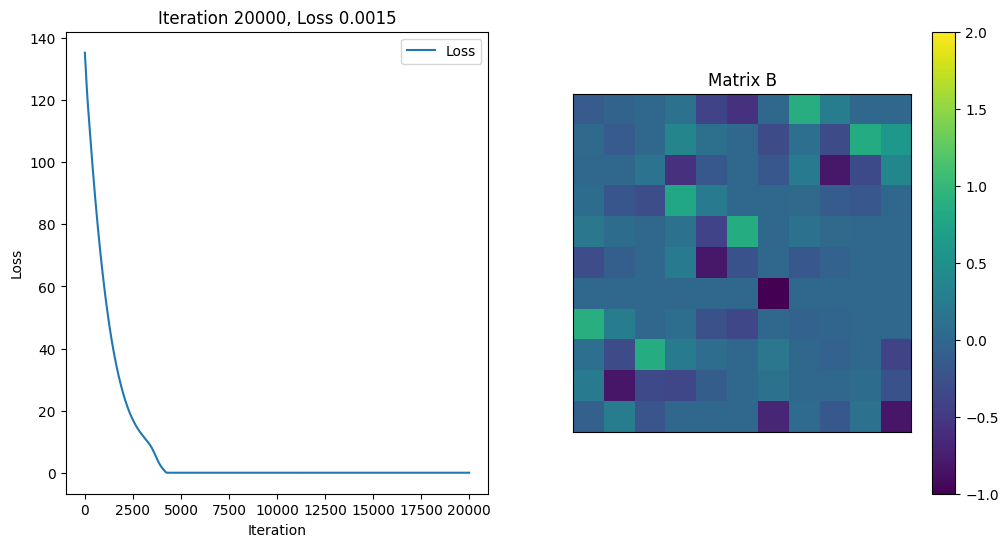

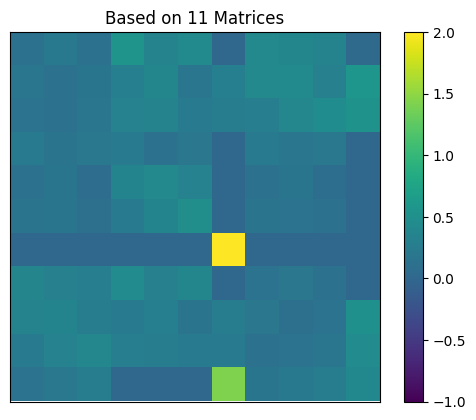

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[1, 7]]=0;
B[[1, 11]]=0;
B[[5, 3]]=0;
B[[5, 10]]=0;
B[[8, 7]]=0;
B[[11, 4]]=0;
[[1, 7], [1, 11], [4, 7], [4, 11], [5, 3], [5, 7], [5, 10], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 7], [8, 11], [11, 4], [11, 5], [11, 6]]


Set b[8,6]=0 using m9 and b[8,1]!=0

In [ ]:
zero_indices = [[1, 7], [1, 11], [4, 7], [4, 11], [5, 3], [5, 7], [5, 10], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 7], [8, 11], [11, 4], [11, 5], [11, 6], [8,6]]
zero_list = convert_indices_zerolist(zero_indices)

0.0020796615


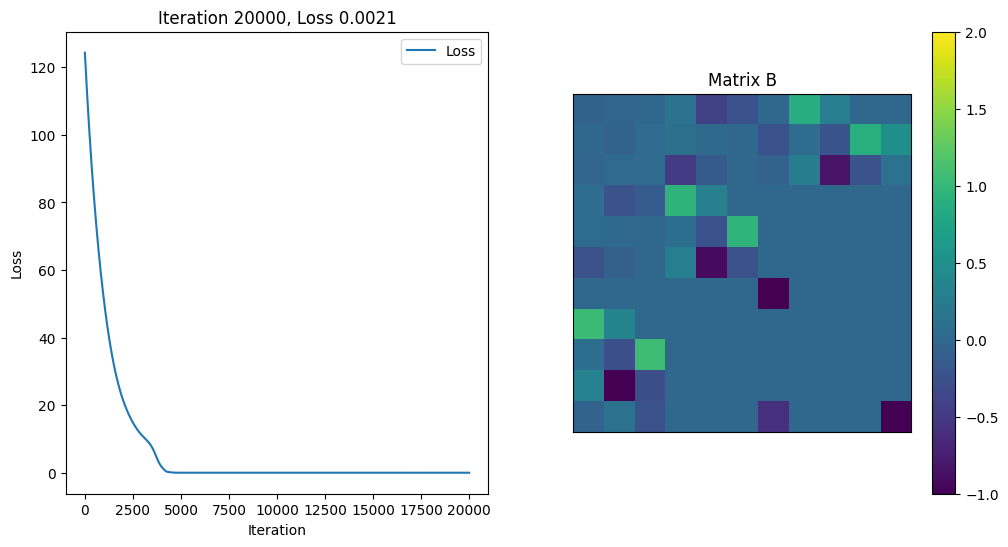

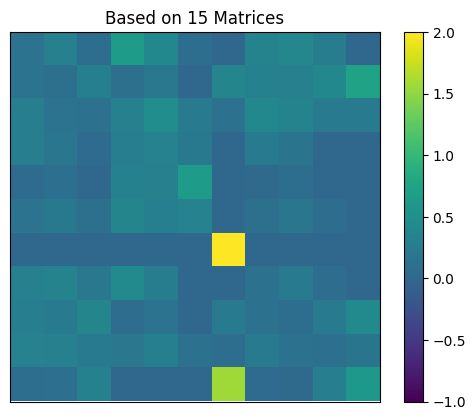

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[1, 3]]=0;
B[[1, 6]]=0;
B[[2, 6]]=0;
B[[4, 3]]=0;
B[[4, 10]]=0;
B[[5, 1]]=0;
B[[5, 2]]=0;
B[[5, 8]]=0;
B[[5, 9]]=0;
B[[6, 10]]=0;
B[[8, 10]]=0;
B[[9, 4]]=0;
B[[9, 6]]=0;
B[[9, 9]]=0;
B[[10, 7]]=0;
B[[10, 10]]=0;
B[[11, 1]]=0;
B[[11, 2]]=0;
B[[11, 8]]=0;
B[[11, 9]]=0;
[[1, 3], [1, 6], [1, 7], [1, 11], [2, 6], [4, 3], [4, 7], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 6], [8, 7], [8, 10], [8, 11], [9, 4], [9, 6], [9, 9], [10, 7], [10, 10], [11, 1], [11, 2], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9]]


Set b[8,5]=0 using m10 and b[8,1]!=0

In [ ]:
zero_indices = [[1, 3], [1, 6], [1, 7], [1, 11], [2, 6], [4, 3], [4, 7], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 6], [8, 7], [8, 10], [8, 11], [9, 4], [9, 6], [9, 9], [10, 7], [10, 10], [11, 1], [11, 2], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [8,5]]
zero_list = convert_indices_zerolist(zero_indices)

0.0017941153


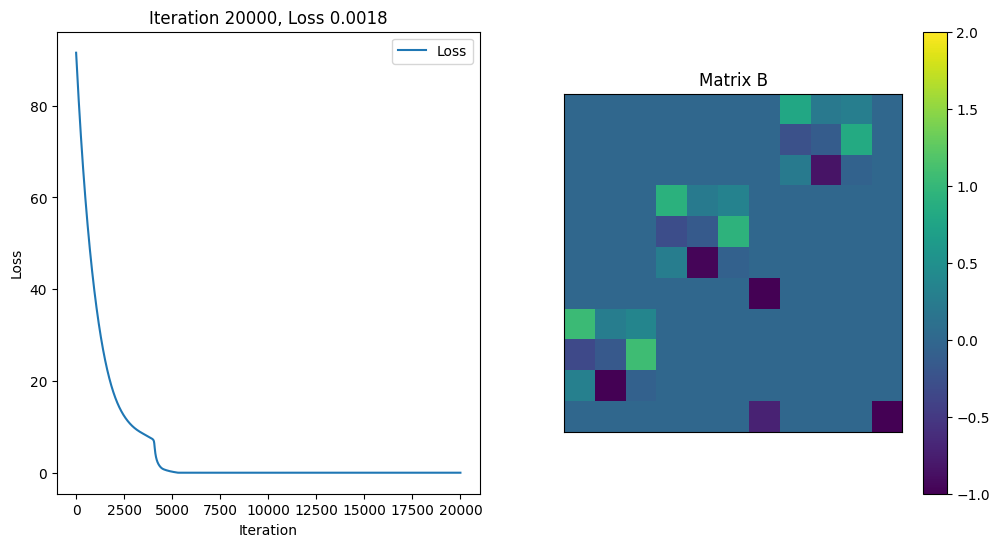

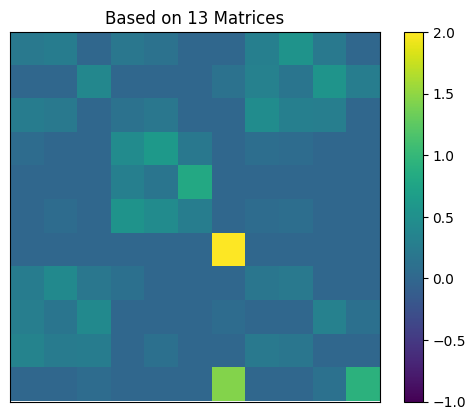

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[2, 1]]=0;
B[[2, 2]]=0;
B[[2, 4]]=0;
B[[2, 5]]=0;
B[[3, 3]]=0;
B[[3, 6]]=0;
B[[3, 7]]=0;
B[[3, 11]]=0;
B[[4, 1]]=0;
B[[4, 2]]=0;
B[[4, 8]]=0;
B[[4, 9]]=0;
B[[6, 1]]=0;
B[[6, 2]]=0;
B[[6, 3]]=0;
B[[6, 8]]=0;
B[[6, 9]]=0;
B[[9, 5]]=0;
B[[9, 7]]=0;
B[[9, 8]]=0;
B[[10, 4]]=0;
B[[10, 6]]=0;
B[[10, 11]]=0;
B[[11, 3]]=0;
[[1, 3], [1, 6], [1, 7], [1, 11], [2, 1], [2, 2], [2, 4], [2, 5], [2, 6], [3, 3], [3, 6], [3, 7], [3, 11], [4, 1], [4, 2], [4, 3], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 5], [8, 6], [8, 7], [8, 10], [8, 11], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9], [10, 4], [10, 6], [10, 7], [10, 10], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9]]


In [ ]:
[[1, 3], [1, 6], [1, 7], [1, 11], [2, 1], [2, 2], [2, 4], [2, 5], [2, 6], [3, 3], [3, 6], [3, 7], [3, 11], [4, 1], [4, 2], [4, 3], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 5], [8, 6], [8, 7], [8, 10], [8, 11], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9], [10, 4], [10, 6], [10, 7], [10, 10], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9]]

Retry same configuration with new info

In [ ]:
zero_indices = [[1, 3], [1, 6], [1, 7], [1, 11], [2, 1], [2, 2], [2, 4], [2, 5], [2, 6], [3, 3], [3, 6], [3, 7], [3, 11], [4, 1], [4, 2], [4, 3], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 5], [8, 6], [8, 7], [8, 10], [8, 11], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9], [10, 4], [10, 6], [10, 7], [10, 10], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9]]
zero_list = convert_indices_zerolist(zero_indices)

4.9377193


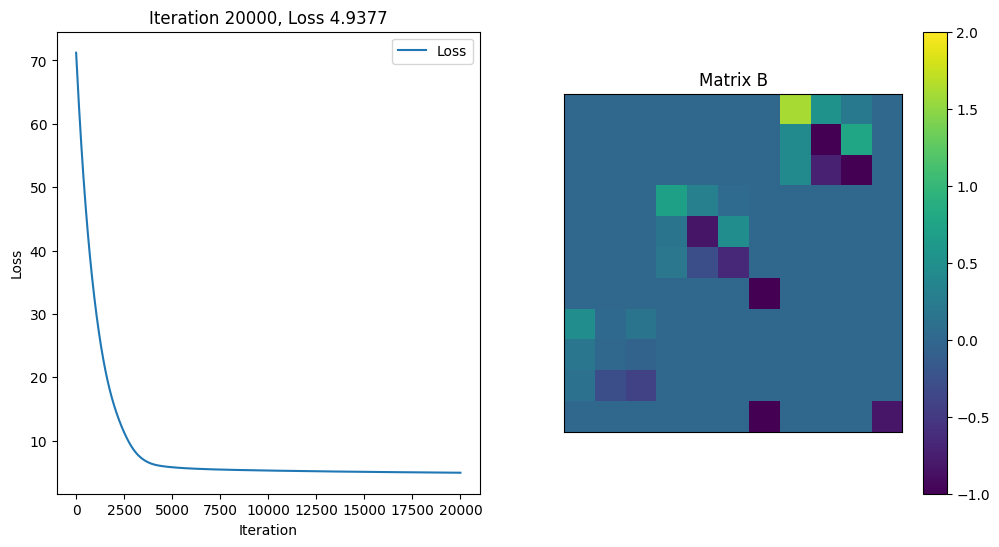

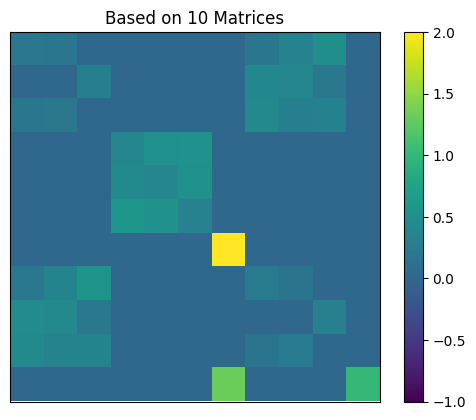

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[1, 4]]=0;
B[[1, 5]]=0;
B[[2, 7]]=0;
B[[2, 11]]=0;
B[[3, 4]]=0;
B[[3, 5]]=0;
B[[8, 4]]=0;
B[[9, 11]]=0;
B[[10, 5]]=0;
B[[11, 10]]=0;
[[1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 11], [2, 1], [2, 2], [2, 4], [2, 5], [2, 6], [2, 7], [2, 11], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 11], [4, 1], [4, 2], [4, 3], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 4], [8, 5], [8, 6], [8, 7], [8, 10], [8, 11], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9], [9, 11], [10, 4], [10, 5], [10, 6], [10, 7], [10, 10], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10]]


In [ ]:
[[1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 11], [2, 1], [2, 2], [2, 4], [2, 5], [2, 6], [2, 7], [2, 11], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 11], [4, 1], [4, 2], [4, 3], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 4], [8, 5], [8, 6], [8, 7], [8, 10], [8, 11], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9], [9, 11], [10, 4], [10, 5], [10, 6], [10, 7], [10, 10], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10]]

Nu kijken naar nonlinear conditions

# Laplace Final Poging 5

In [ ]:
# 11 generators, order
N_gen = 11

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_lapl = jnp.zeros((N_gen,N_gen,N_gen))

# Commutator values from commutation table [row, column, result, structure constant value]
# Can also be read as [gen_1, gen_2, result_gen, structure constant value]
commutation_relations = [[1,5,3,-1],[1,6,2,1],  # |  [P_1, J_i]
                         [2,4,3,1],[2,6,1,-1],  # |  [P_2, J_i]
                         [3,4,2,-1],[3,5,1,1],  # |  [P_3, J_i]
                         [4,5,6,-1],[4,6,5,1],  # |  [J_1, J_i]
                         [5,6,4,-1],            # |  [J_2, J_3]          same structure constants as helmholtz
                         [11,1,1,-1],[11,2,2,-1],[11,3,3,-1],    # [D, P_i]
                         [11,8,8,1],[11,9,9,1],[11,10,10,1],     # [D, J_i]
                         [1,8,7,-1],[1,8,11,2],[1,9,6,-2],[1,10,5,2],  # [P_1, K_i]
                         [2,8,6,2],[2,9,7,-1],[2,9,11,2],[2,10,4,-2],  # [P_2, K_i]
                         [3,8,5,-2],[3,9,4,2],[3,10,7,-1],[3,10,11,2], # [P_3, K_i]
                         [4,9,10,-1],[4,10,9,1],[5,8,10,1],[5,10,8,-1],[6,8,9,-1],[6,9,8,1]]  #[K_i, K_j]

c_lapl = comms_to_matrix(commutation_relations, N_gen)

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals, solver=None):

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_lapl,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_lapl,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  @jit
  def updater(params, opt_state):
    grad_adam = grad_loss(params)
    updates, opt_state = solver.update(grad_adam, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = random.uniform(key, shape=(N_gen,N_gen),minval=-2, maxval=2)

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    # Use ADAM Solver
    solver = optax.adam(l_rate)
    params = B_init
    opt_state = solver.init(params)

    for iter in range(iterations):
      grad_adam = grad_loss(params)

      params, opt_state = updater(params, opt_state)
      params = keep_constant(params, zero_list)

      param_loss = loss(params)
      loss_values.append(loss(params))

      #if param_loss < cutoff:
      #  break


    clear_output(wait=True)

    # Use final result as B matrix
    B = params
    last_loss = loss(B)
    print(last_loss)

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Iteration {len(loss_values)}, Loss {last_loss:.4f}')

    # Showing the matrix B
    plt.subplot(1, 2, 2)
    plt.imshow(B, cmap='viridis', vmin=-1, vmax=2)
    plt.colorbar()
    plt.title('Matrix B')
    plt.xticks([])
    plt.yticks([])

    display(plt.gcf())
    plt.close()

    if last_loss < 1:
      B_list[idx] = B
    else:
      zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

In [ ]:
N = 30
learning_rate = 6e-4
iterations = 20_000

Poging zonder info

2.5896375


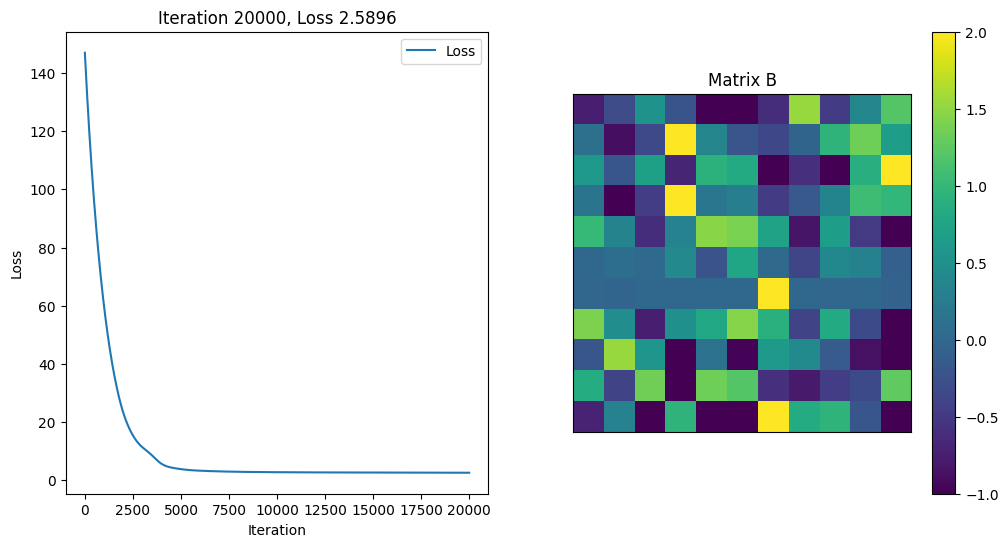

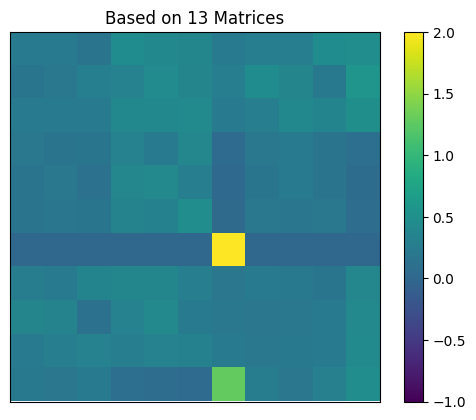

In [ ]:
# Tuple of rows and columns of each known zero entry
zero_list = ((),())
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_list)
print(new_zero_indices)

New indices: 
B[[4, 7]]=0;
B[[4, 11]]=0;
B[[5, 7]]=0;
B[[5, 11]]=0;
B[[6, 7]]=0;
B[[6, 11]]=0;
B[[7, 1]]=0;
B[[7, 2]]=0;
B[[7, 3]]=0;
B[[7, 4]]=0;
B[[7, 5]]=0;
B[[7, 6]]=0;
B[[7, 8]]=0;
B[[7, 9]]=0;
B[[7, 10]]=0;
B[[7, 11]]=0;
B[[11, 5]]=0;
B[[11, 6]]=0;
[[4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [11, 5], [11, 6]]


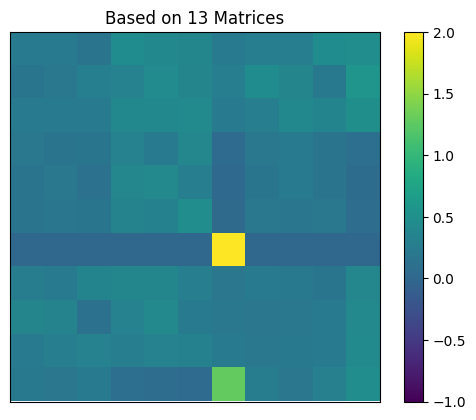

In [ ]:
save_normfig("lapl5-noadj-adam-thresh0.1-cutoff1-n30-l6e4-i20_000")

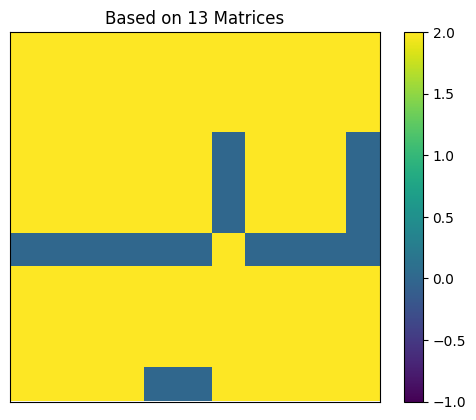

In [ ]:
save_binfig("lapl5-noadj-adam-highl0.1-thresh0.1-cutoff1-n30-l6e4-i20_000", 0.1)

## Assumption: b[8,1]!=0 (set b[8,11]=b[8,6]=b[8,5]=0 one after the other using m8, m9, m10 respectively)

In [ ]:
# Copy paste printed out list of zero indices and add these three new values
zero_indices = [[4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [11, 5], [11, 6], [8,11]]
zero_list = convert_indices_zerolist(zero_indices)

0.0015016019


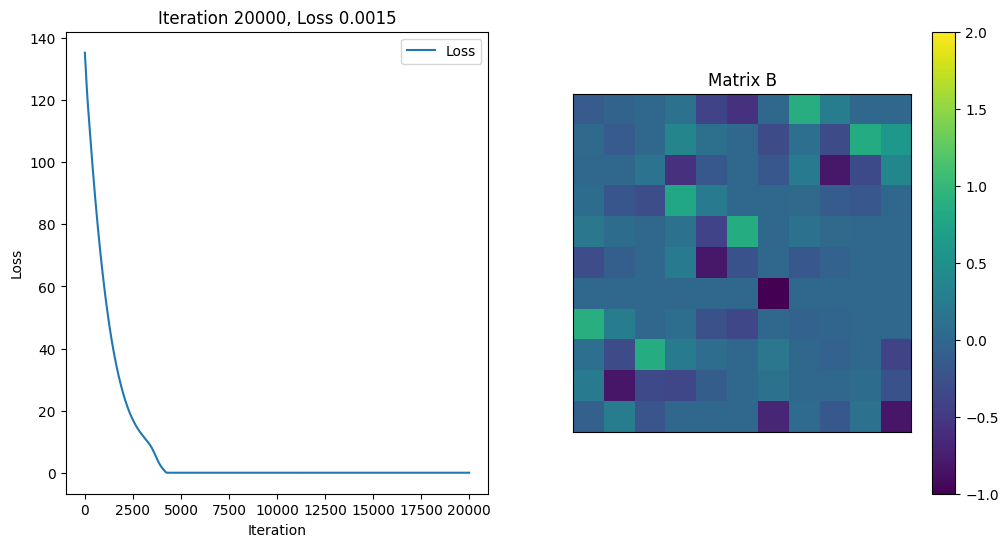

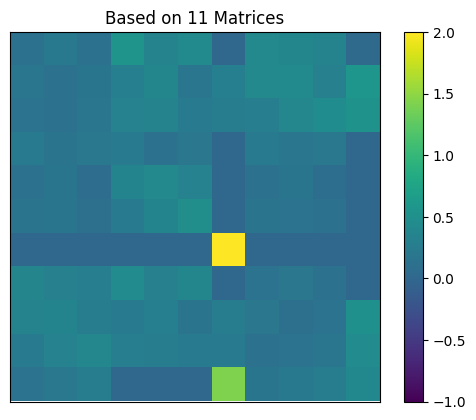

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_list)
print(new_zero_indices)

New indices: 
B[[1, 7]]=0;
B[[1, 11]]=0;
B[[4, 7]]=0;
B[[4, 11]]=0;
B[[5, 3]]=0;
B[[5, 7]]=0;
B[[5, 10]]=0;
B[[5, 11]]=0;
B[[6, 7]]=0;
B[[6, 11]]=0;
B[[7, 1]]=0;
B[[7, 2]]=0;
B[[7, 3]]=0;
B[[7, 4]]=0;
B[[7, 5]]=0;
B[[7, 6]]=0;
B[[7, 8]]=0;
B[[7, 9]]=0;
B[[7, 10]]=0;
B[[7, 11]]=0;
B[[8, 7]]=0;
B[[8, 11]]=0;
B[[11, 4]]=0;
B[[11, 5]]=0;
B[[11, 6]]=0;
[[1, 7], [1, 11], [4, 7], [4, 11], [5, 3], [5, 7], [5, 10], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 7], [8, 11], [11, 4], [11, 5], [11, 6]]


Set b[8,6]=0 using m9

In [ ]:
# Copy paste printed out list of zero indices and add these three new values
zero_indices = [[1, 7], [1, 11], [4, 7], [4, 11], [5, 3], [5, 7], [5, 10], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 7], [8, 11], [11, 4], [11, 5], [11, 6], [8,6]]
zero_list = convert_indices_zerolist(zero_indices)

0.0020796615


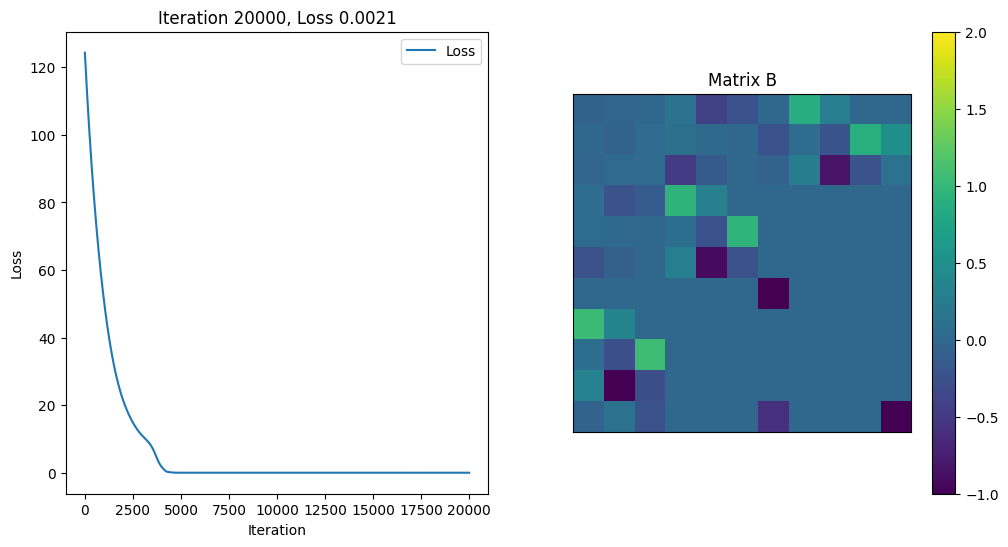

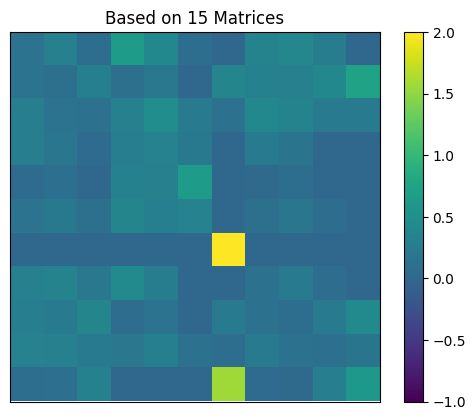

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_list)
print(new_zero_indices)

New indices: 
B[[1, 3]]=0;
B[[1, 6]]=0;
B[[1, 7]]=0;
B[[1, 11]]=0;
B[[2, 6]]=0;
B[[4, 3]]=0;
B[[4, 7]]=0;
B[[4, 10]]=0;
B[[4, 11]]=0;
B[[5, 1]]=0;
B[[5, 2]]=0;
B[[5, 3]]=0;
B[[5, 7]]=0;
B[[5, 8]]=0;
B[[5, 9]]=0;
B[[5, 10]]=0;
B[[5, 11]]=0;
B[[6, 7]]=0;
B[[6, 10]]=0;
B[[6, 11]]=0;
B[[7, 1]]=0;
B[[7, 2]]=0;
B[[7, 3]]=0;
B[[7, 4]]=0;
B[[7, 5]]=0;
B[[7, 6]]=0;
B[[7, 8]]=0;
B[[7, 9]]=0;
B[[7, 10]]=0;
B[[7, 11]]=0;
B[[8, 6]]=0;
B[[8, 7]]=0;
B[[8, 10]]=0;
B[[8, 11]]=0;
B[[9, 4]]=0;
B[[9, 6]]=0;
B[[9, 9]]=0;
B[[10, 7]]=0;
B[[10, 10]]=0;
B[[11, 1]]=0;
B[[11, 2]]=0;
B[[11, 4]]=0;
B[[11, 5]]=0;
B[[11, 6]]=0;
B[[11, 8]]=0;
B[[11, 9]]=0;
[[1, 3], [1, 6], [1, 7], [1, 11], [2, 6], [4, 3], [4, 7], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 6], [8, 7], [8, 10], [8, 11], [9, 4], [9, 6], [9, 9], [10, 7], [10, 10], [11, 1], [11, 2], [11, 4], [11, 5], [11,

Set b[8,5]=0

In [ ]:
# Copy paste printed out list of zero indices and add these three new values
zero_indices = [[1, 3], [1, 6], [1, 7], [1, 11], [2, 6], [4, 3], [4, 7], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 6], [8, 7], [8, 10], [8, 11], [9, 4], [9, 6], [9, 9], [10, 7], [10, 10], [11, 1], [11, 2], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [8,5]]
zero_list = convert_indices_zerolist(zero_indices)

0.0017941153


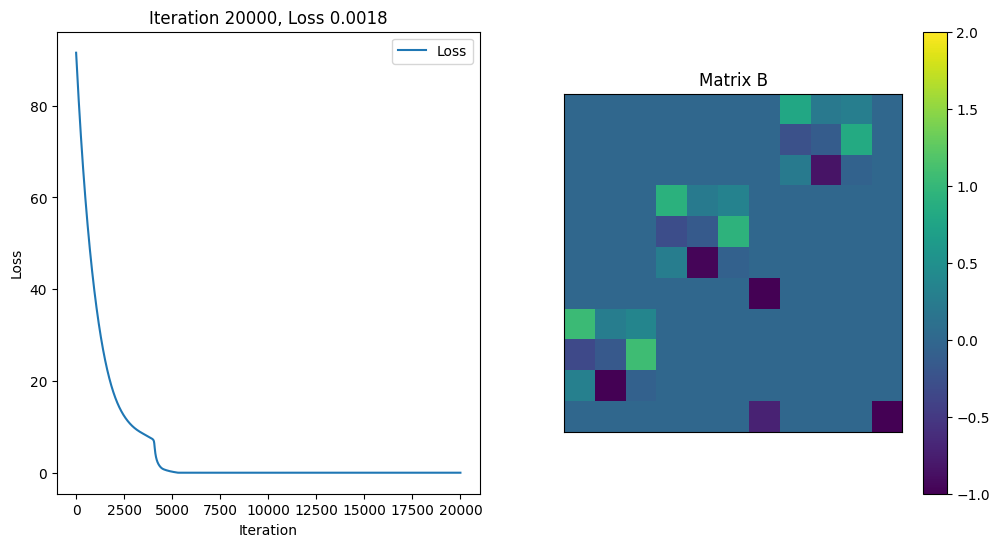

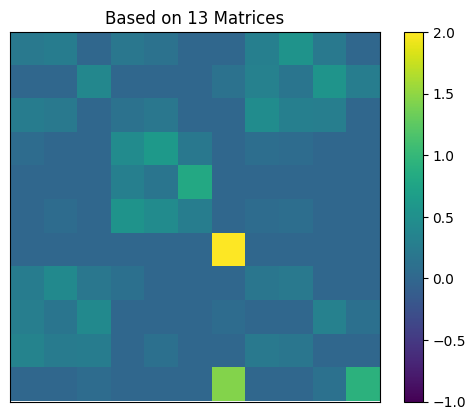

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_list)
print(new_zero_indices)

New indices: 
B[[1, 3]]=0;
B[[1, 6]]=0;
B[[1, 7]]=0;
B[[1, 11]]=0;
B[[2, 1]]=0;
B[[2, 2]]=0;
B[[2, 4]]=0;
B[[2, 5]]=0;
B[[2, 6]]=0;
B[[3, 3]]=0;
B[[3, 6]]=0;
B[[3, 7]]=0;
B[[3, 11]]=0;
B[[4, 1]]=0;
B[[4, 2]]=0;
B[[4, 3]]=0;
B[[4, 7]]=0;
B[[4, 8]]=0;
B[[4, 9]]=0;
B[[4, 10]]=0;
B[[4, 11]]=0;
B[[5, 1]]=0;
B[[5, 2]]=0;
B[[5, 3]]=0;
B[[5, 7]]=0;
B[[5, 8]]=0;
B[[5, 9]]=0;
B[[5, 10]]=0;
B[[5, 11]]=0;
B[[6, 1]]=0;
B[[6, 2]]=0;
B[[6, 3]]=0;
B[[6, 7]]=0;
B[[6, 8]]=0;
B[[6, 9]]=0;
B[[6, 10]]=0;
B[[6, 11]]=0;
B[[7, 1]]=0;
B[[7, 2]]=0;
B[[7, 3]]=0;
B[[7, 4]]=0;
B[[7, 5]]=0;
B[[7, 6]]=0;
B[[7, 8]]=0;
B[[7, 9]]=0;
B[[7, 10]]=0;
B[[7, 11]]=0;
B[[8, 5]]=0;
B[[8, 6]]=0;
B[[8, 7]]=0;
B[[8, 10]]=0;
B[[8, 11]]=0;
B[[9, 4]]=0;
B[[9, 5]]=0;
B[[9, 6]]=0;
B[[9, 7]]=0;
B[[9, 8]]=0;
B[[9, 9]]=0;
B[[10, 4]]=0;
B[[10, 6]]=0;
B[[10, 7]]=0;
B[[10, 10]]=0;
B[[10, 11]]=0;
B[[11, 1]]=0;
B[[11, 2]]=0;
B[[11, 3]]=0;
B[[11, 4]]=0;
B[[11, 5]]=0;
B[[11, 6]]=0;
B[[11, 8]]=0;
B[[11, 9]]=0;
[[1, 3], [1, 6], [1, 7], [1, 11], [2

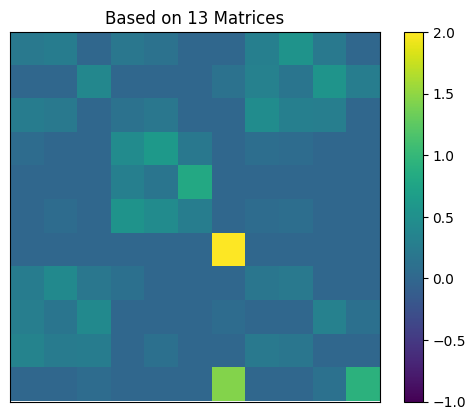

In [ ]:
save_normfig("lapl5-adj8910-adam-thresh0.1-cutoff1-n30-l6e4-i20_000")

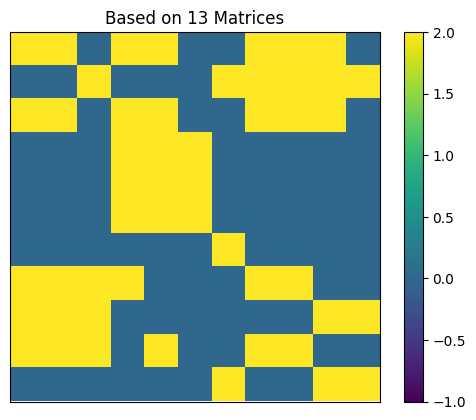

In [ ]:
save_binfig("lapl5-adj8910-adam-highl0.1-thresh0.1-cutoff1-n30-l6e4-i20_000", 0.1)

rerun

In [ ]:
# Copy paste printed out list of zero indices and add these three new values
zero_indices = [[1, 3], [1, 6], [1, 7], [1, 11], [2, 1], [2, 2], [2, 4], [2, 5], [2, 6], [3, 3], [3, 6], [3, 7], [3, 11], [4, 1], [4, 2], [4, 3], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 5], [8, 6], [8, 7], [8, 10], [8, 11], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9], [10, 4], [10, 6], [10, 7], [10, 10], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9]]
zero_list = convert_indices_zerolist(zero_indices)

4.9377193


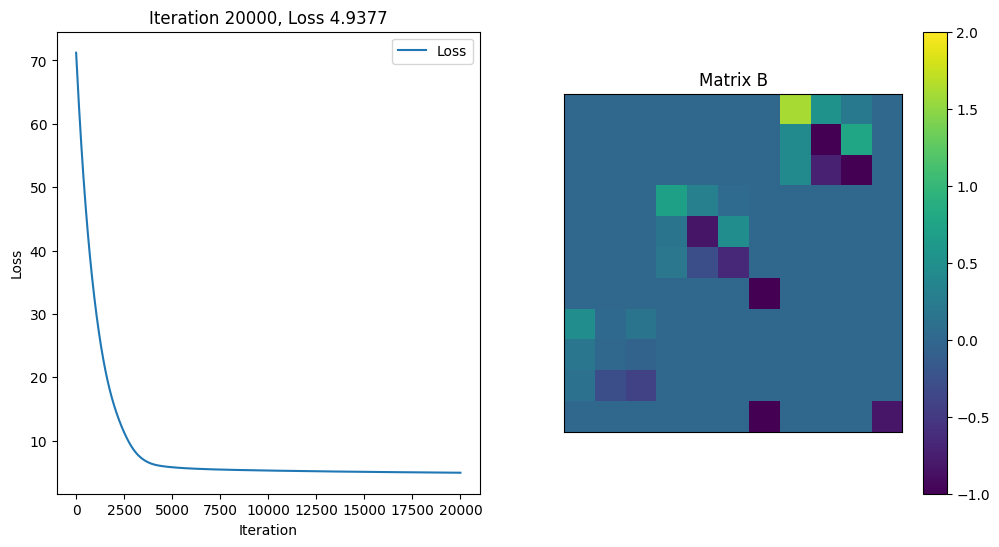

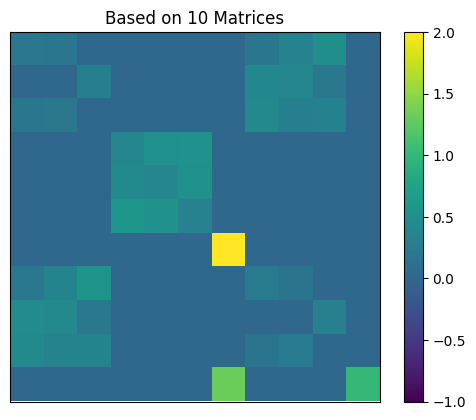

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_list)
print(new_zero_indices)

New indices: 
B[[1, 3]]=0;
B[[1, 4]]=0;
B[[1, 5]]=0;
B[[1, 6]]=0;
B[[1, 7]]=0;
B[[1, 11]]=0;
B[[2, 1]]=0;
B[[2, 2]]=0;
B[[2, 4]]=0;
B[[2, 5]]=0;
B[[2, 6]]=0;
B[[2, 7]]=0;
B[[2, 11]]=0;
B[[3, 3]]=0;
B[[3, 4]]=0;
B[[3, 5]]=0;
B[[3, 6]]=0;
B[[3, 7]]=0;
B[[3, 11]]=0;
B[[4, 1]]=0;
B[[4, 2]]=0;
B[[4, 3]]=0;
B[[4, 7]]=0;
B[[4, 8]]=0;
B[[4, 9]]=0;
B[[4, 10]]=0;
B[[4, 11]]=0;
B[[5, 1]]=0;
B[[5, 2]]=0;
B[[5, 3]]=0;
B[[5, 7]]=0;
B[[5, 8]]=0;
B[[5, 9]]=0;
B[[5, 10]]=0;
B[[5, 11]]=0;
B[[6, 1]]=0;
B[[6, 2]]=0;
B[[6, 3]]=0;
B[[6, 7]]=0;
B[[6, 8]]=0;
B[[6, 9]]=0;
B[[6, 10]]=0;
B[[6, 11]]=0;
B[[7, 1]]=0;
B[[7, 2]]=0;
B[[7, 3]]=0;
B[[7, 4]]=0;
B[[7, 5]]=0;
B[[7, 6]]=0;
B[[7, 8]]=0;
B[[7, 9]]=0;
B[[7, 10]]=0;
B[[7, 11]]=0;
B[[8, 4]]=0;
B[[8, 5]]=0;
B[[8, 6]]=0;
B[[8, 7]]=0;
B[[8, 10]]=0;
B[[8, 11]]=0;
B[[9, 4]]=0;
B[[9, 5]]=0;
B[[9, 6]]=0;
B[[9, 7]]=0;
B[[9, 8]]=0;
B[[9, 9]]=0;
B[[9, 11]]=0;
B[[10, 4]]=0;
B[[10, 5]]=0;
B[[10, 6]]=0;
B[[10, 7]]=0;
B[[10, 10]]=0;
B[[10, 11]]=0;
B[[11, 1]]=0;
B[[11, 2]]=0;


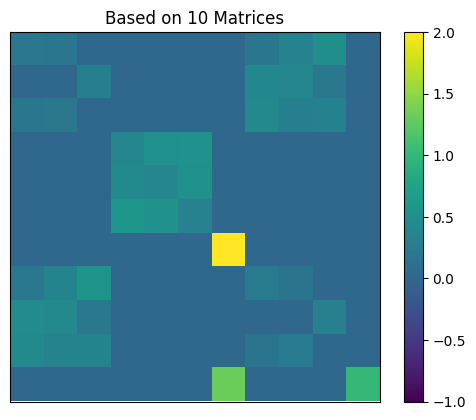

In [ ]:
save_normfig("lapl5-adj8910-rerun-adam-thresh0.1-cutoff1-n30-l6e4-i20_000")

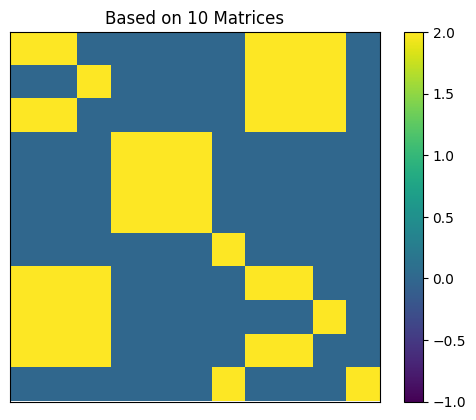

In [ ]:
save_binfig("lapl5-adj8910-rerun-adam-highl0.1-thresh0.1-cutoff1-n30-l6e4-i20_000", 0.1)

In [ ]:
[[1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 11], [2, 1], [2, 2], [2, 4], [2, 5], [2, 6], [2, 7], [2, 11], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 11], [4, 1], [4, 2], [4, 3], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 4], [8, 5], [8, 6], [8, 7], [8, 10], [8, 11], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9], [9, 11], [10, 4], [10, 5], [10, 6], [10, 7], [10, 10], [10, 11], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10]]

## Assumption: b[8,1]=0

In [ ]:
# Copy paste printed out list of zero indices and add these three new values
zero_indices = [[4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [11, 5], [11, 6], [8,1]]
zero_list = convert_indices_zerolist(zero_indices)

0.0016748774


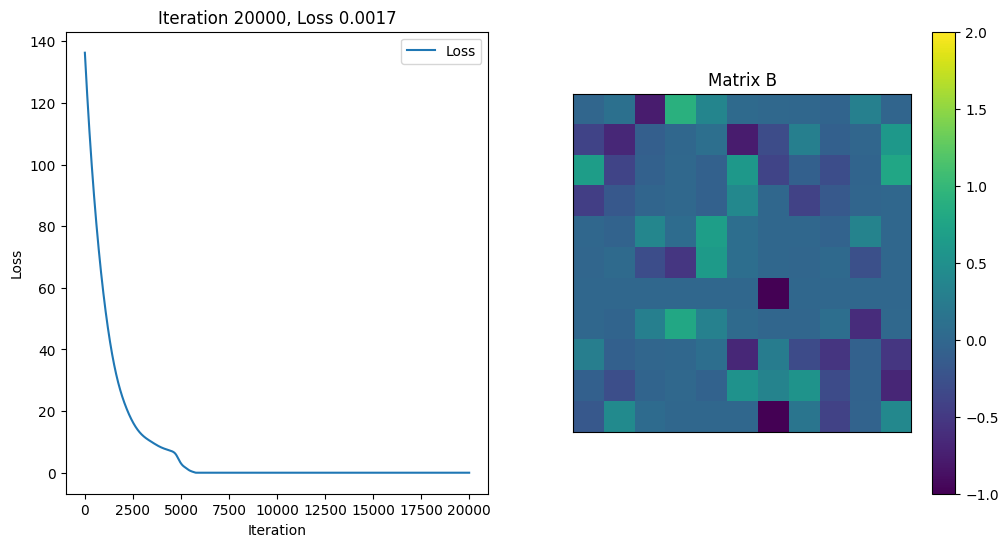

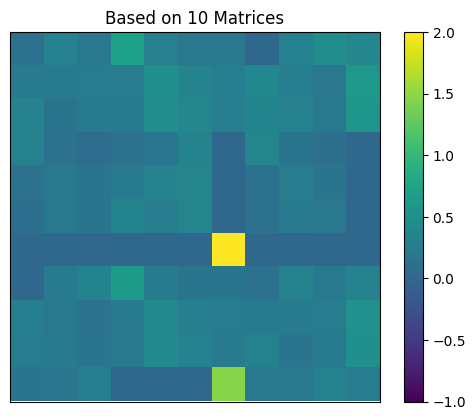

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[1, 8]]=0;
B[[4, 3]]=0;
B[[11, 4]]=0;
[[1, 8], [4, 3], [4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 1], [11, 4], [11, 5], [11, 6]]


In [ ]:
# Copy paste printed out list of zero indices and add these three new values
zero_indices = [[1, 8], [4, 3], [4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 1], [11, 4], [11, 5], [11, 6], [1,11]]
zero_list = convert_indices_zerolist(zero_indices)

3.0509522


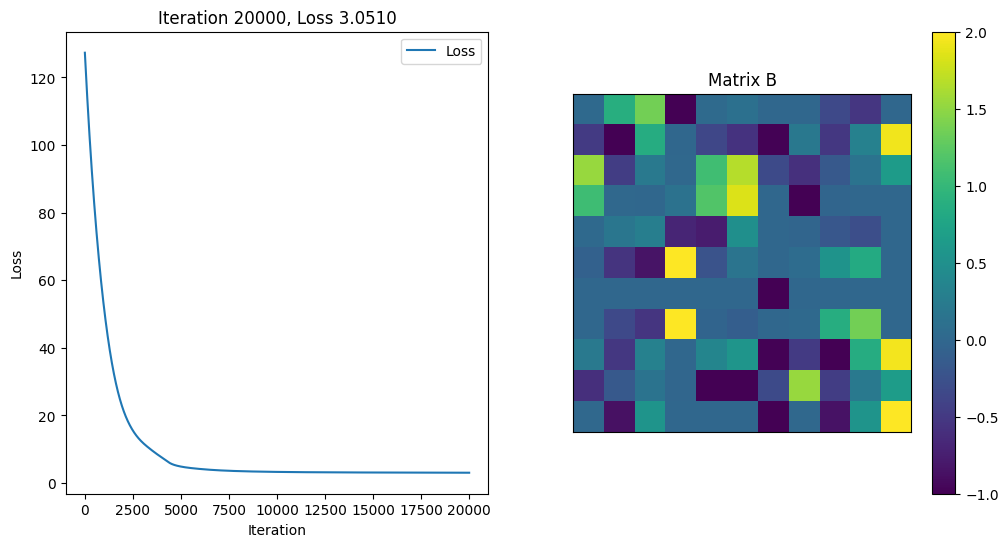

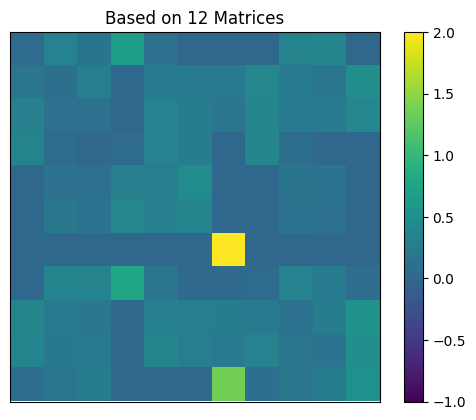

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[1, 1]]=0;
B[[1, 6]]=0;
B[[1, 7]]=0;
B[[2, 4]]=0;
B[[3, 4]]=0;
B[[4, 2]]=0;
B[[4, 4]]=0;
B[[4, 9]]=0;
B[[4, 10]]=0;
B[[5, 1]]=0;
B[[5, 8]]=0;
B[[6, 1]]=0;
B[[6, 8]]=0;
B[[8, 6]]=0;
B[[8, 7]]=0;
B[[8, 8]]=0;
B[[8, 11]]=0;
B[[9, 4]]=0;
B[[10, 4]]=0;
B[[11, 1]]=0;
B[[11, 8]]=0;
[[1, 1], [1, 6], [1, 7], [1, 8], [1, 11], [2, 4], [3, 4], [4, 2], [4, 3], [4, 4], [4, 7], [4, 9], [4, 10], [4, 11], [5, 1], [5, 7], [5, 8], [5, 11], [6, 1], [6, 7], [6, 8], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 1], [8, 6], [8, 7], [8, 8], [8, 11], [9, 4], [10, 4], [11, 1], [11, 4], [11, 5], [11, 6], [11, 8]]


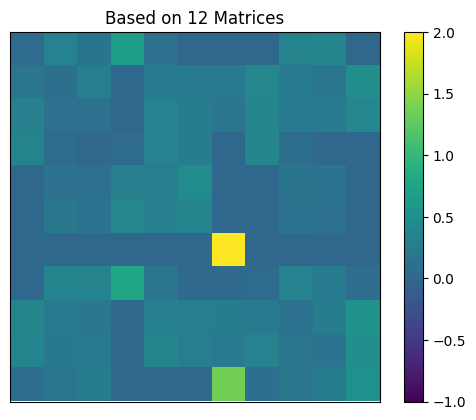

In [ ]:
save_normfig("lapl5-noadj(b11!=0)-adam-thresh0.1-cutoff1-n30-l6e4-i20_000")

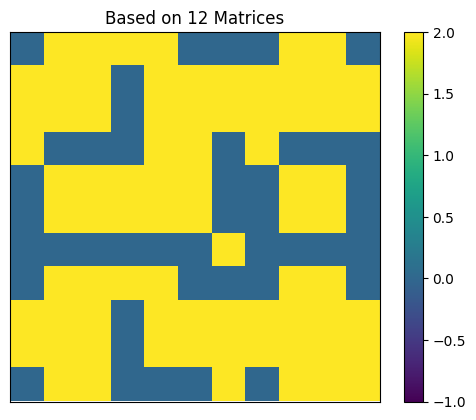

In [ ]:
save_binfig("lapl5-noadj(b11!=0)-adam-highl0.1-thresh0.1-cutoff1-n30-l6e4-i20_000", 0.1)

### Assumption: b[2,1]!=0 (set b[2,7]=0 using m8)

In [ ]:
# Copy paste printed out list of zero indices and add these three new values
zero_indices = [[1, 8], [4, 3], [4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 1], [11, 4], [11, 5], [11, 6], [3,7]]
zero_list = convert_indices_zerolist(zero_indices)

3.0783687


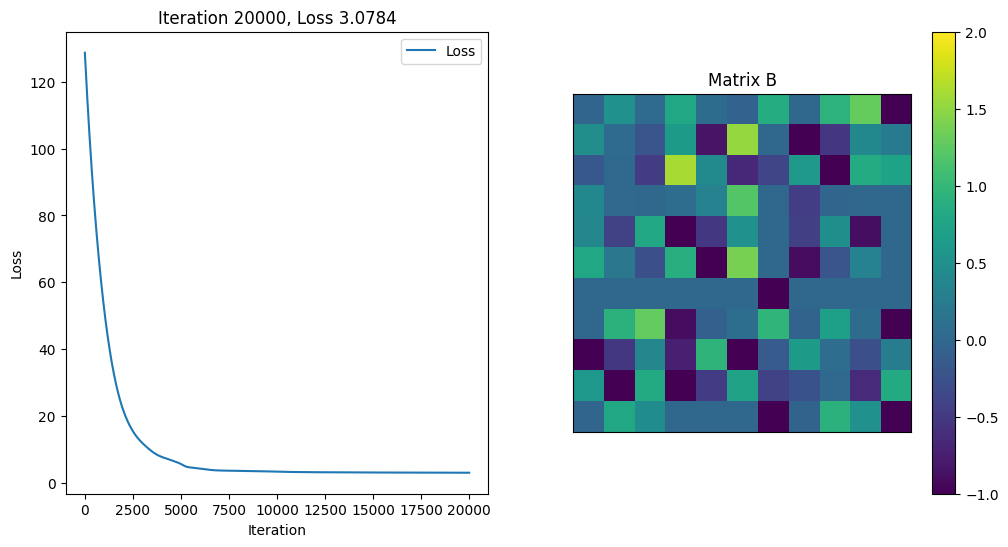

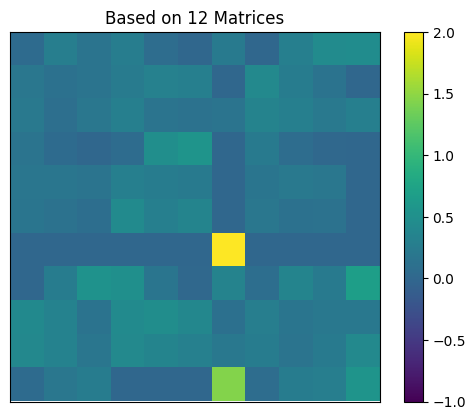

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[1, 1]]=0;
B[[1, 5]]=0;
B[[1, 6]]=0;
B[[2, 11]]=0;
B[[3, 2]]=0;
B[[4, 2]]=0;
B[[4, 4]]=0;
B[[4, 9]]=0;
B[[4, 10]]=0;
B[[6, 3]]=0;
B[[8, 6]]=0;
B[[8, 8]]=0;
B[[11, 1]]=0;
B[[11, 8]]=0;
[[1, 1], [1, 5], [1, 6], [1, 8], [2, 7], [2, 11], [3, 2], [4, 2], [4, 3], [4, 4], [4, 7], [4, 9], [4, 10], [4, 11], [5, 7], [5, 11], [6, 3], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 1], [8, 6], [8, 8], [11, 1], [11, 4], [11, 5], [11, 6], [11, 8]]


Set b[2,6]=0 using m9

In [ ]:
# Copy paste printed out list of zero indices and add these three new values
zero_indices = [[1, 1], [1, 5], [1, 6], [1, 8], [2, 7], [2, 11], [3, 2], [4, 2], [4, 3], [4, 4], [4, 7], [4, 9], [4, 10], [4, 11], [5, 7], [5, 11], [6, 3], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 1], [8, 6], [8, 8], [11, 1], [11, 4], [11, 5], [11, 6], [11, 8], [2,6]]
zero_list = convert_indices_zerolist(zero_indices)

0.0019796689


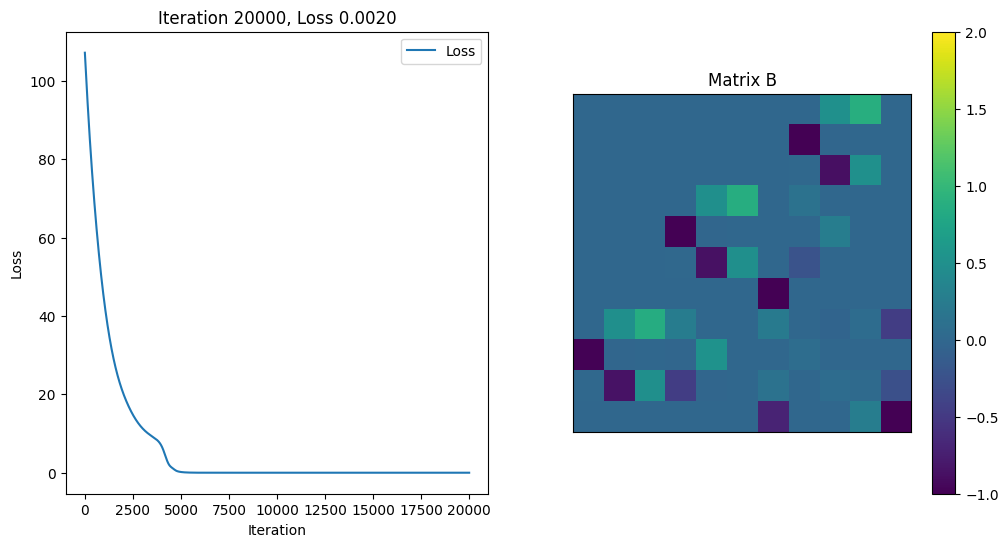

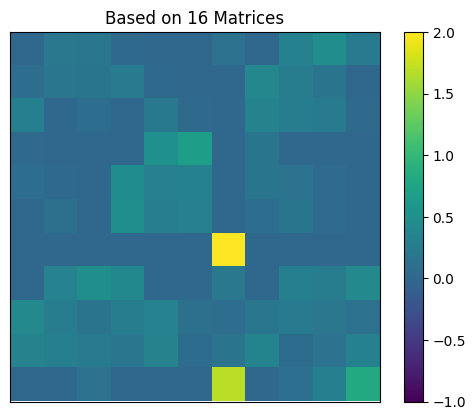

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[1, 4]]=0;
B[[2, 1]]=0;
B[[2, 5]]=0;
B[[3, 3]]=0;
B[[3, 4]]=0;
B[[3, 6]]=0;
B[[3, 7]]=0;
B[[3, 11]]=0;
B[[4, 1]]=0;
B[[5, 1]]=0;
B[[5, 2]]=0;
B[[5, 3]]=0;
B[[5, 10]]=0;
B[[6, 1]]=0;
B[[6, 8]]=0;
B[[6, 10]]=0;
B[[8, 5]]=0;
B[[9, 7]]=0;
B[[10, 6]]=0;
B[[10, 9]]=0;
B[[11, 2]]=0;
B[[11, 9]]=0;
[[1, 1], [1, 4], [1, 5], [1, 6], [1, 8], [2, 1], [2, 5], [2, 6], [2, 7], [2, 11], [3, 2], [3, 3], [3, 4], [3, 6], [3, 7], [3, 11], [4, 1], [4, 2], [4, 3], [4, 4], [4, 7], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 10], [5, 11], [6, 1], [6, 3], [6, 7], [6, 8], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 1], [8, 5], [8, 6], [8, 8], [9, 7], [10, 6], [10, 9], [11, 1], [11, 2], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9]]


## Trying out u -> -u symmetry vinden

In [ ]:
# Copy paste printed out list of zero indices and add these three new values
zero_indices = [[1, 7], [1, 8], [1, 9], [1, 10], [2, 7], [2, 8], [2, 9], [2, 10], [3, 7], [3, 8], [3, 9], [3, 10], [4, 7], [4, 8], [4, 9], [4, 10], [5, 7], [5, 8], [5, 9], [5, 10], [6, 7], [6, 8], [6, 9], [6, 10], [7, 8], [7, 9], [7, 10], [8, 7], [8, 9], [8, 10], [9, 7], [9, 8], [9, 10], [10, 7], [10, 8], [10, 9]]
zero_list = convert_indices_zerolist(zero_indices)

0.0014623906


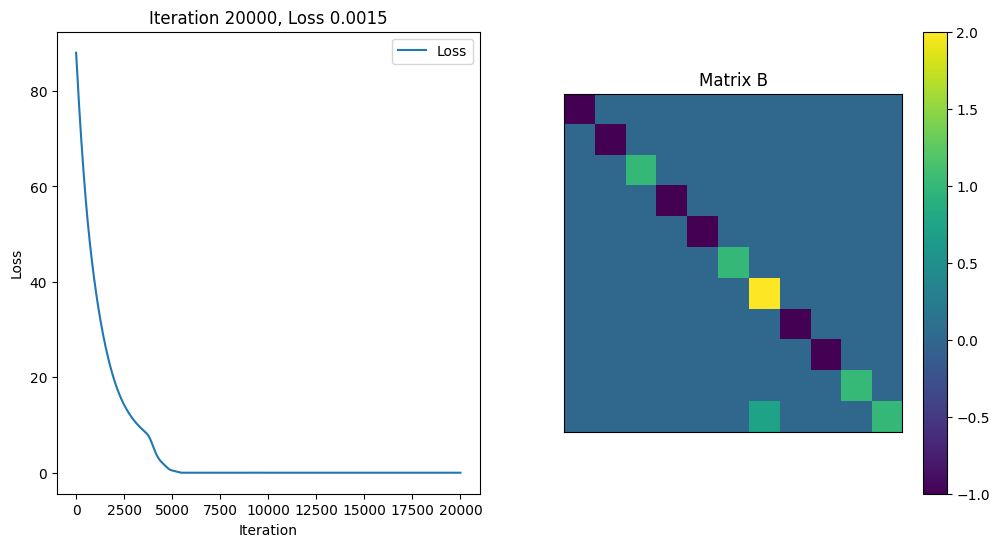

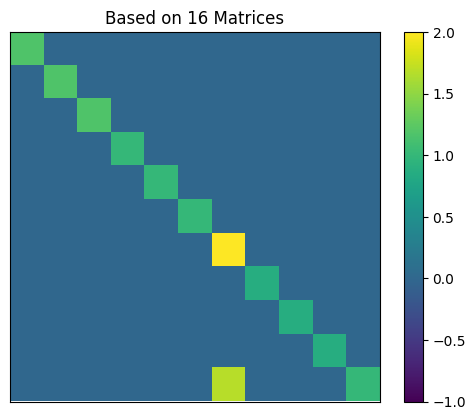

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

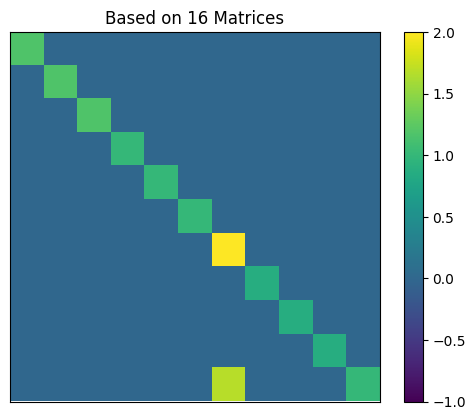

In [ ]:
save_normfig("lapl6-minu-noadj-adam-thresh0.1-cutoff1-n30-l6e4-i20_000")

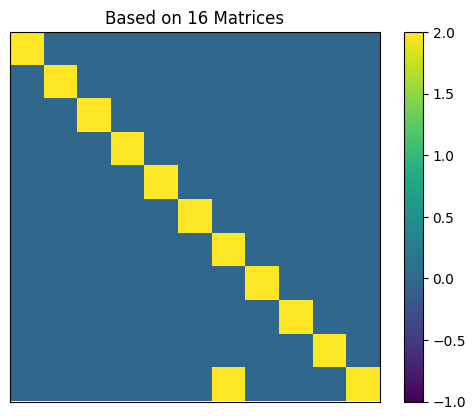

In [ ]:
save_binfig("lapl6-minu-noadj-adam-highl0.1-thresh0.1-cutoff1-n30-l6e4-i20_000", 0.1)

Zelfde proberen maar dan alleen met v1, v2, v3 nul laten zijn op utilde

In [ ]:
# Copy paste printed out list of zero indices and add these three new values
zero_indices = [[1, 7], [1, 8], [1, 9], [1, 10], [2, 7], [2, 8], [2, 9], [2, 10], [3, 7], [3, 8], [3, 9], [3, 10]]
zero_list = convert_indices_zerolist(zero_indices)

0.004021138


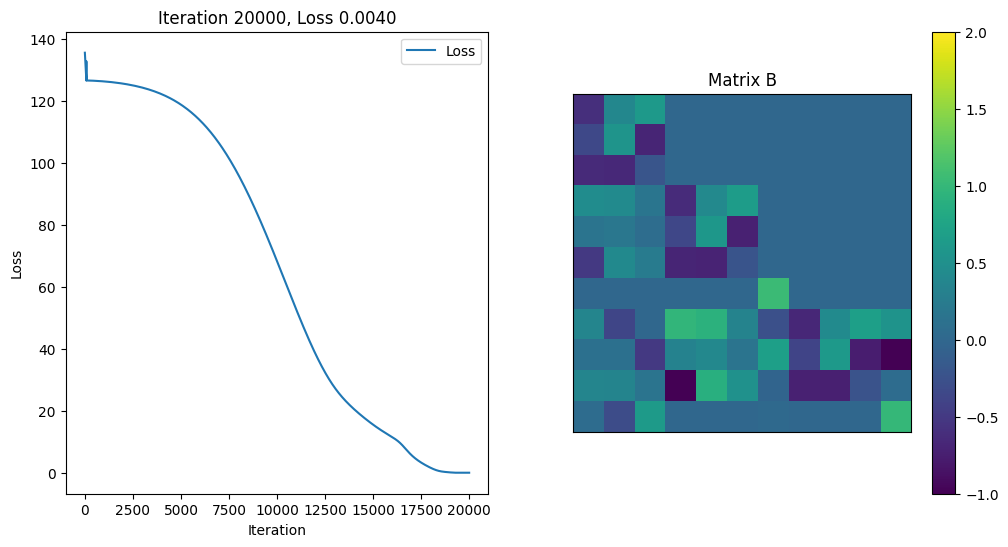

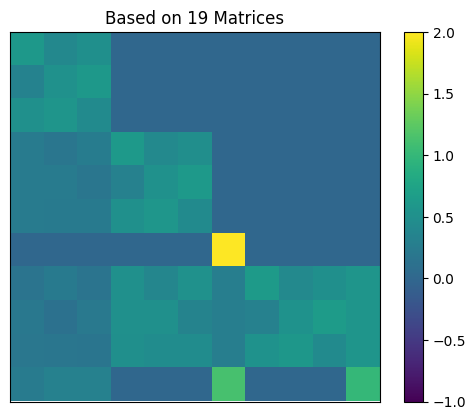

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[1, 4]]=0;
B[[1, 5]]=0;
B[[1, 6]]=0;
B[[1, 11]]=0;
B[[2, 4]]=0;
B[[2, 5]]=0;
B[[2, 6]]=0;
B[[2, 11]]=0;
B[[3, 4]]=0;
B[[3, 5]]=0;
B[[3, 6]]=0;
B[[3, 11]]=0;
B[[4, 7]]=0;
B[[4, 8]]=0;
B[[4, 9]]=0;
B[[4, 10]]=0;
B[[4, 11]]=0;
B[[5, 7]]=0;
B[[5, 8]]=0;
B[[5, 9]]=0;
B[[5, 10]]=0;
B[[5, 11]]=0;
B[[6, 7]]=0;
B[[6, 8]]=0;
B[[6, 9]]=0;
B[[6, 10]]=0;
B[[6, 11]]=0;
B[[7, 1]]=0;
B[[7, 2]]=0;
B[[7, 3]]=0;
B[[7, 4]]=0;
B[[7, 5]]=0;
B[[7, 6]]=0;
B[[7, 8]]=0;
B[[7, 9]]=0;
B[[7, 10]]=0;
B[[7, 11]]=0;
B[[11, 4]]=0;
B[[11, 5]]=0;
B[[11, 6]]=0;
B[[11, 8]]=0;
B[[11, 9]]=0;
B[[11, 10]]=0;
[[1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [1

Rerun new info?

In [ ]:
# Copy paste printed out list of zero indices
zero_indices = [[1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [11, 4], [11, 5], [11, 6], [11, 8], [11, 9], [11, 10]]
zero_list = convert_indices_zerolist(zero_indices)

8.384381


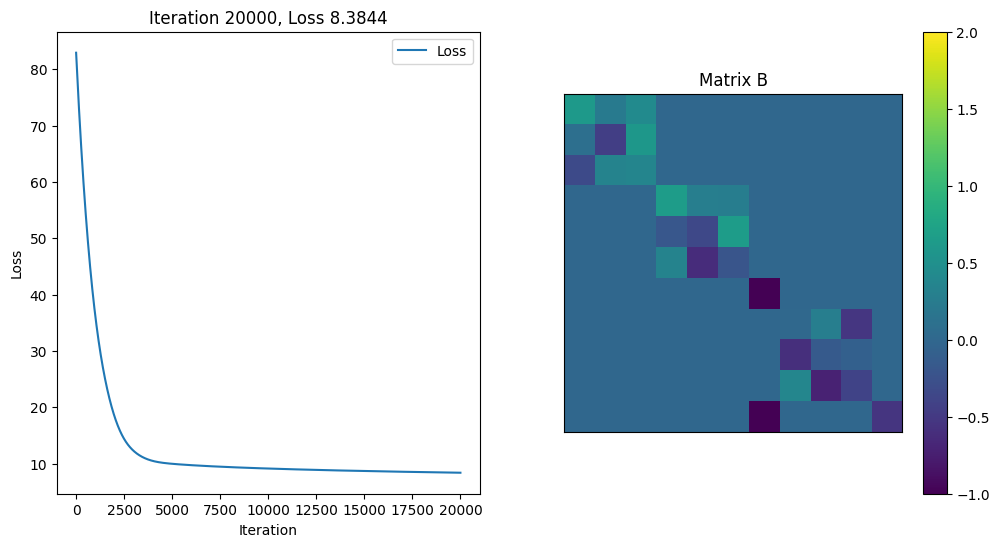

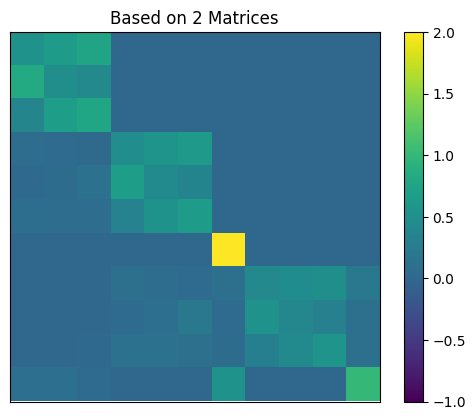

In [ ]:
# Tuple of rows and columns of each known zero entry
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

# Laplace Eq Unif(-1,1) probeersel

In [ ]:
# 11 generators, order
N_gen = 11

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_lapl = jnp.zeros((N_gen,N_gen,N_gen))

# Commutator values from commutation table [row, column, result, structure constant value]
# Can also be read as [gen_1, gen_2, result_gen, structure constant value]
commutation_relations = [[1,5,3,-1],[1,6,2,1],  # |  [P_1, J_i]
                         [2,4,3,1],[2,6,1,-1],  # |  [P_2, J_i]
                         [3,4,2,-1],[3,5,1,1],  # |  [P_3, J_i]
                         [4,5,6,-1],[4,6,5,1],  # |  [J_1, J_i]
                         [5,6,4,-1],            # |  [J_2, J_3]          same structure constants as helmholtz
                         [11,1,1,-1],[11,2,2,-1],[11,3,3,-1],    # [D, P_i]
                         [11,8,8,1],[11,9,9,1],[11,10,10,1],     # [D, J_i]
                         [1,8,7,-1],[1,8,11,2],[1,9,6,-2],[1,10,5,2],  # [P_1, K_i]
                         [2,8,6,2],[2,9,7,-1],[2,9,11,2],[2,10,4,-2],  # [P_2, K_i]
                         [3,8,5,-2],[3,9,4,2],[3,10,7,-1],[3,10,11,2], # [P_3, K_i]
                         [4,9,10,-1],[4,10,9,1],[5,8,10,1],[5,10,8,-1],[6,8,9,-1],[6,9,8,1]]  #[K_i, K_j]

c_lapl = comms_to_matrix(commutation_relations, N_gen)

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals, solver=None):

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_lapl,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_lapl,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  @jit
  def updater(params, opt_state):
    grad_adam = grad_loss(params)
    updates, opt_state = solver.update(grad_adam, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = random.uniform(key, shape=(N_gen,N_gen),minval=-1, maxval=1)

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    # Use ADAM Solver
    solver = optax.adam(l_rate)
    params = B_init
    opt_state = solver.init(params)

    for iter in range(iterations):
      grad_adam = grad_loss(params)

      params, opt_state = updater(params, opt_state)
      params = keep_constant(params, zero_list)

      param_loss = loss(params)
      loss_values.append(loss(params))

      #if param_loss < cutoff:
      #  break


    clear_output(wait=True)

    # Use final result as B matrix
    B = params
    last_loss = loss(B)
    print(last_loss)

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Iteration {len(loss_values)}, Loss {last_loss:.4f}')

    # Showing the matrix B
    plt.subplot(1, 2, 2)
    plt.imshow(B, cmap='viridis', vmin=-1, vmax=2)
    plt.colorbar()
    plt.title('Matrix B')
    plt.xticks([])
    plt.yticks([])

    display(plt.gcf())
    plt.close()

    if last_loss < 1:
      B_list[idx] = B
    else:
      zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

Eerste poging zonder info

In [ ]:
N = 30
learning_rate = 6e-4
iterations = 20_000

0.002268104


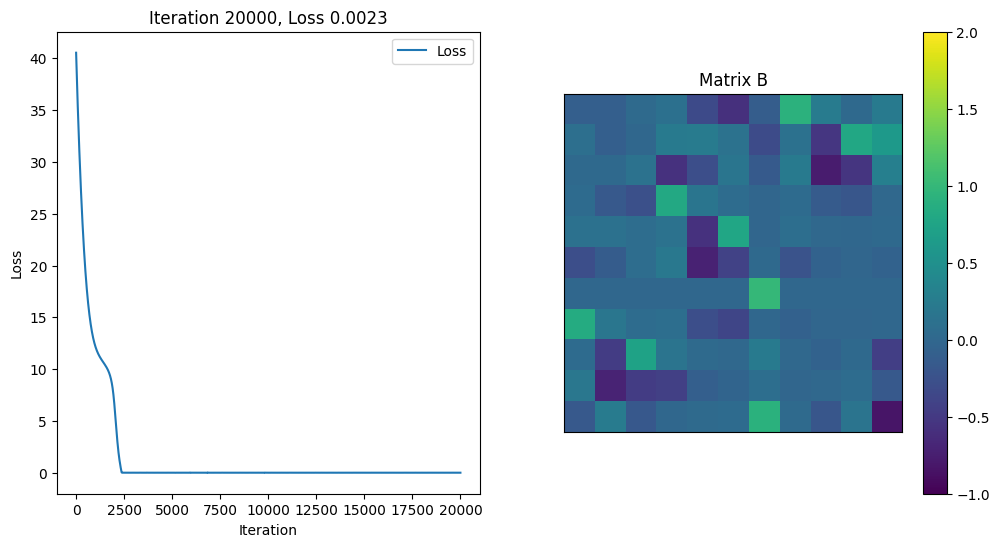

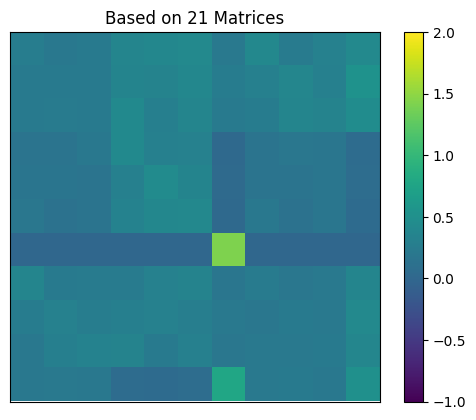

In [ ]:
# Tuple of rows and columns of each known zero entry
zero_list = ((),())
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

# Test Dingen

2.68528


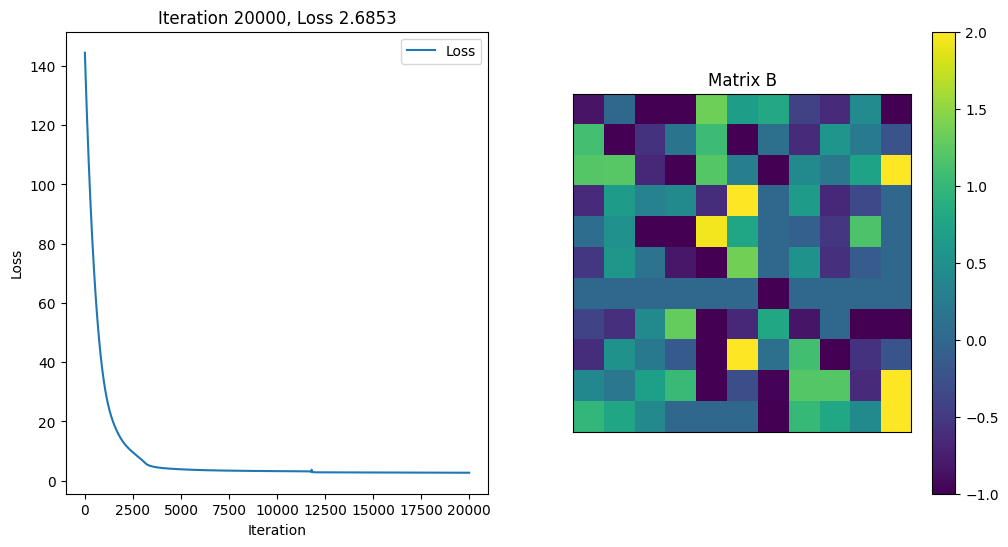

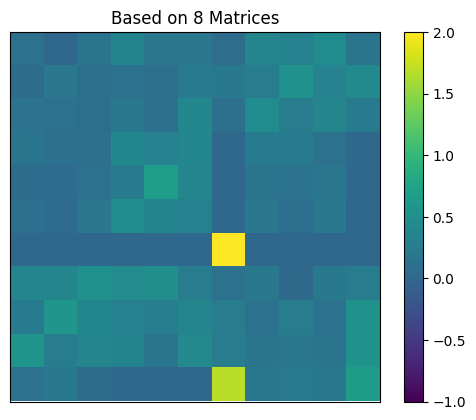

In [ ]:
# Wat als alleen b[1,2]=0?
#zero_indices = [[4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [11, 4], [11, 5], [11, 6],[1,2]]

# Tuple of rows and columns of each known zero entry
zero_list = convert_indices_zerolist(zero_indices)
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

2.700189


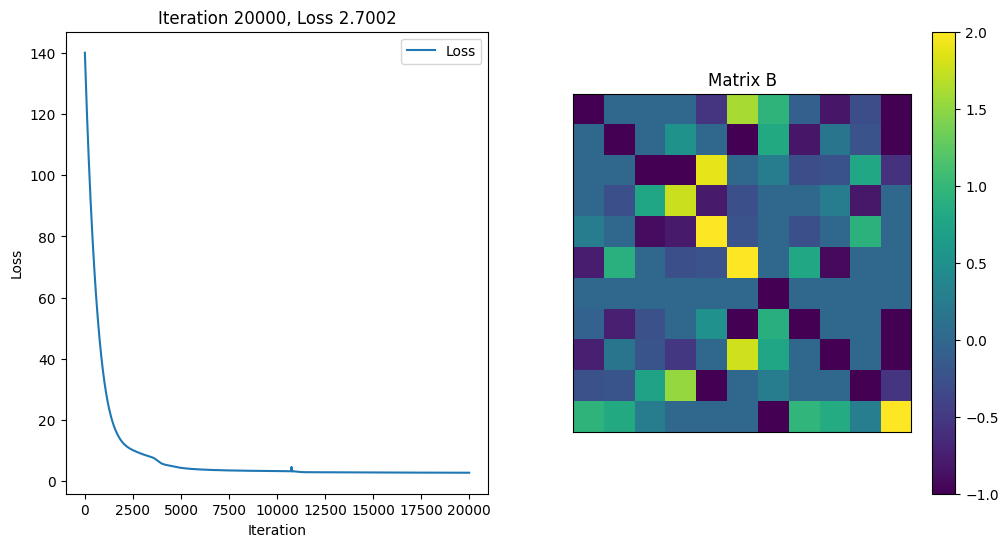

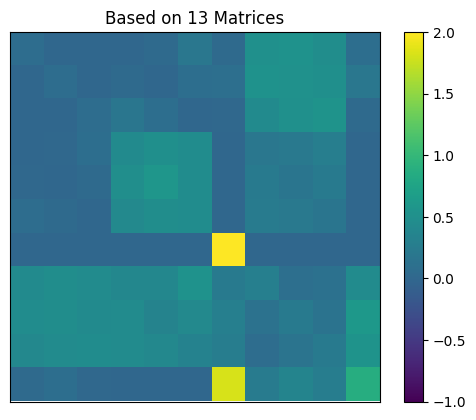

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 20_000

# indices of all zero b values
zero_indices = [[4, 7], [4, 11], [5, 7], [5, 11], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [11, 4], [11, 5], [11, 6],[1,2],[1,3],[2,1],[2,3],[3,1],[3,2]]

# Tuple of rows and columns of each known zero entry
zero_list = convert_indices_zerolist(zero_indices)
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[1, 1]]=0;
B[[1, 4]]=0;
B[[1, 5]]=0;
B[[1, 7]]=0;
B[[1, 11]]=0;
B[[2, 2]]=0;
B[[2, 4]]=0;
B[[2, 5]]=0;
B[[2, 6]]=0;
B[[2, 7]]=0;
B[[3, 3]]=0;
B[[3, 5]]=0;
B[[3, 6]]=0;
B[[3, 7]]=0;
B[[3, 11]]=0;
B[[4, 1]]=0;
B[[4, 2]]=0;
B[[4, 3]]=0;
B[[5, 1]]=0;
B[[5, 2]]=0;
B[[5, 3]]=0;
B[[6, 1]]=0;
B[[6, 2]]=0;
B[[6, 3]]=0;
B[[8, 9]]=0;
B[[10, 8]]=0;
B[[11, 1]]=0;
B[[11, 2]]=0;
B[[11, 3]]=0;
[[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 7], [1, 11], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [3, 1], [3, 2], [3, 3], [3, 5], [3, 6], [3, 7], [3, 11], [4, 1], [4, 2], [4, 3], [4, 7], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 11], [6, 1], [6, 2], [6, 3], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 9], [10, 8], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6]]


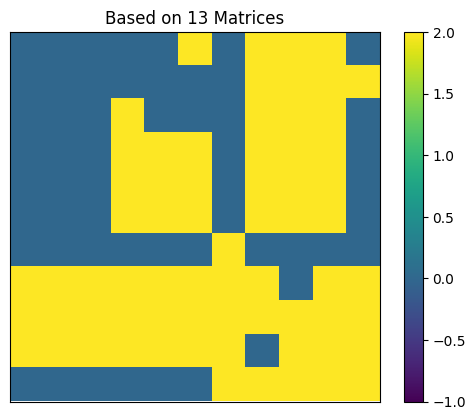

In [ ]:
zero_highlighter(B_sum, 0.1, zero_determinant_counter)

## Assumption: b[8,1]!= 0 (Sets b[8,7]=b[8,6]=b[8,5]=0 using m8,9,10 respectively)

4.7354813


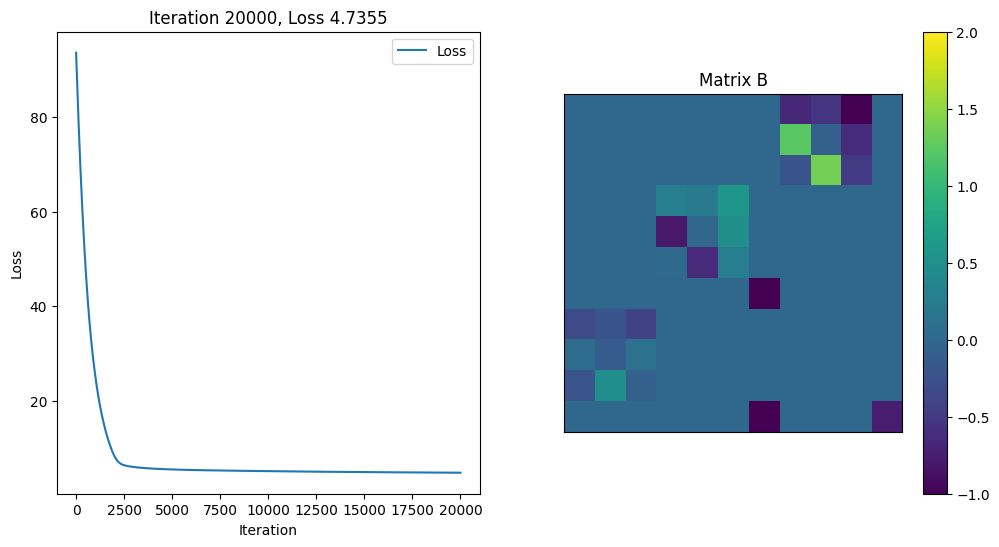

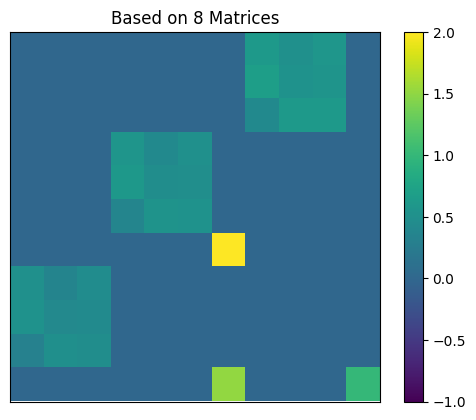

In [ ]:
# Number of sims
N = 25
learning_rate = 1e-3
iterations = 20_000

# indices of all zero b values
zero_indices = [[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 7], [1, 11], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [3, 1], [3, 2], [3, 3], [3, 5], [3, 6], [3, 7], [3, 11], [4, 1], [4, 2], [4, 3], [4, 7], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 11], [6, 1], [6, 2], [6, 3], [6, 7], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 9], [10, 8], [11, 1], [11, 2], [11, 3], [11, 4], [11, 5], [11, 6], [8,7],[8,6],[8,5]]

# Tuple of rows and columns of each known zero entry
zero_list = convert_indices_zerolist(zero_indices)
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

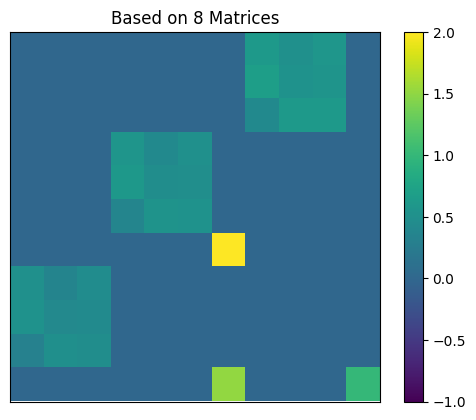

In [ ]:
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.savefig("lapl-adj8910-adam-cutoff1-n25-l1e3-i20_000.pdf",bbox_inches='tight')
plt.savefig("lapl-adj8910-adam-cutoff1-n25-l1e3-i20_000.jpg",bbox_inches='tight')
plt.show()

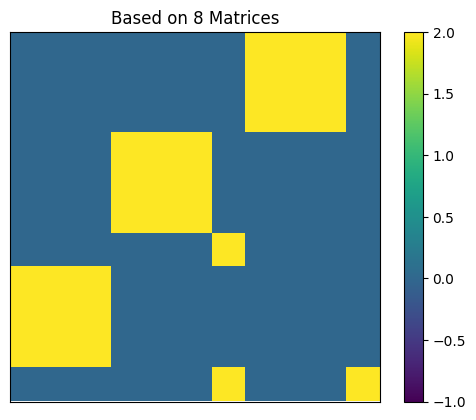

In [ ]:
B_m = np.zeros(np.shape(B_sum))

for (i,j),label in np.ndenumerate(B_sum):
  if label < 0.1:
    B_m[i,j]=0
  else:
    B_m[i,j]=2

plt.imshow(B_m, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])

plt.savefig("lapl-highl0.1-adj8910-adam-cutoff1-n25-l1e3-i20_000.pdf",bbox_inches='tight')
plt.savefig("lapl-highl0.1-adj8910-adam-cutoff1-n25-l1e3-i20_000.jpg",bbox_inches='tight')
plt.show()

In [ ]:
new_zero_indices = give_zero_indices(B_sum, 0.1, zero_indices)
print(new_zero_indices)

New indices: 
B[[1, 6]]=0;
B[[2, 11]]=0;
B[[3, 4]]=0;
B[[4, 8]]=0;
B[[4, 9]]=0;
B[[4, 10]]=0;
B[[5, 8]]=0;
B[[5, 9]]=0;
B[[5, 10]]=0;
B[[6, 8]]=0;
B[[6, 9]]=0;
B[[6, 10]]=0;
B[[8, 4]]=0;
B[[8, 8]]=0;
B[[8, 10]]=0;
B[[8, 11]]=0;
B[[9, 4]]=0;
B[[9, 5]]=0;
B[[9, 6]]=0;
B[[9, 7]]=0;
B[[9, 8]]=0;
B[[9, 9]]=0;
B[[9, 10]]=0;
B[[9, 11]]=0;
B[[10, 4]]=0;
B[[10, 5]]=0;
B[[10, 6]]=0;
B[[10, 7]]=0;
B[[10, 9]]=0;
B[[10, 10]]=0;
B[[10, 11]]=0;
B[[11, 8]]=0;
B[[11, 9]]=0;
B[[11, 10]]=0;
[[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 11], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 11], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 11], [4, 1], [4, 2], [4, 3], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [5, 1], [5, 2], [5, 3], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [6, 1], [6, 2], [6, 3], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 8], [7, 9], [7, 10], [7, 11], [8, 4], [8, 5], [8, 6], [8, 7], [8, 8], [8, 9],

## Kijken of nonl conditions are convex

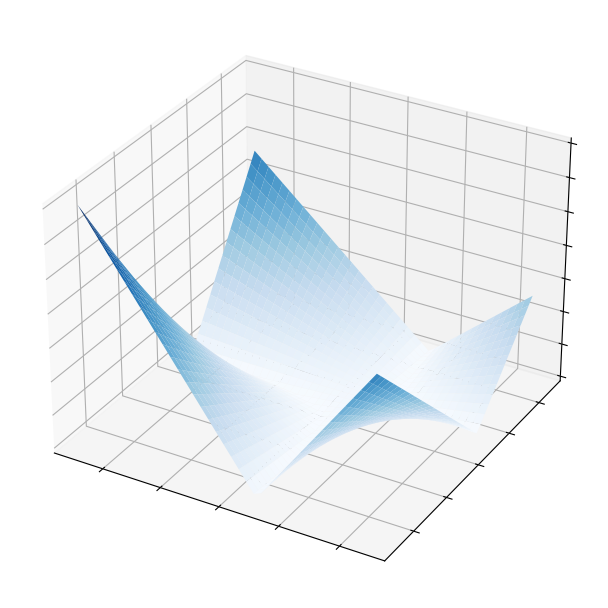

In [ ]:
from matplotlib import cm

plt.style.use('_mpl-gallery')

# Make data
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)

def func(X, Y):
  return X*Y - X - Y


Z = np.sqrt(func(X,Y)**2)

# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6,6))
ax.plot_surface(X, Y, Z, vmin=Z.min() * 2, cmap=cm.Blues)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

plt.show()

# Testing Finding Adj matrix using sympy

In [ ]:
import sympy as smp

In [ ]:
def custom_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return smp.printing.latex(exp,**options)
smp.init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

In [ ]:
# 11 generators, order
N_gen = 11

# Commutator values from commutation table [row, column, result, structure constant value]
# Can also be read as [gen_1, gen_2, result_gen, structure constant value]
commutation_relations = [[1,5,3,-1],[1,6,2,1],  # |
                         [2,4,3,1],[2,6,1,-1],  # |
                         [3,4,2,-1],[3,5,1,1],  # |
                         [4,5,6,-1],[4,6,5,1],  # |
                         [5,6,1,-1],            # |               same structure constants as helmholtz
                         [11,1,1,-1],[11,2,2,-1],[11,3,3,-1],    # [D, P_i]
                         [11,8,8,1],[11,9,9,1],[11,10,10,1],     # [D, J_i]
                         [1,8,7,-1],[1,8,11,2],[1,9,6,-2],[1,10,5,2],  # [P_1, K_i]
                         [2,8,6,2],[2,9,7,-1],[2,9,11,2],[2,10,4,-2],  # [P_2, K_i]
                         [3,8,5,-2],[3,9,4,2],[3,10,7,-1],[3,10,11,2], # [P_3, K_i]
                         [4,9,10,-1],[4,10,9,1],[5,8,10,1],[5,10,8,-1],[6,8,9,-1],[6,9,8,1]]  #[K_i, K_j]

c_lapl_test = comms_to_matrix(commutation_relations, N_gen)

#with np.printoptions(threshold=np.inf):
#    print(c_lapl_test)

In [ ]:
a = smp.Symbol("a")
C1 = smp.Matrix(c_lapl_test[0]) * a

exp_C1 = smp.exp(C1)

In [ ]:
B = smp.Matrix(B_sum)

In [ ]:
# Prints out numbers instead of variables
exp_C1 * B

⎡           0.253496289253235                                0                                        0                             0                                   0.0534369610249996                                                   0.0538331605494022                                    0                       0.369305700063705                                 0                                         0                                         0                     ⎤
⎢                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      ⎥
⎢                   0                                0

In [ ]:
  B_m = np.zeros(np.shape(B_sum))
  for (i,j),label in np.ndenumerate(B_sum):
    if label < 0.01:
      B_m[i,j]=0
    else:
      B_m[i,j]=1

B_pos = smp.Matrix(B_m)

In [ ]:
B = smp.MatrixSymbol('B', 11,11)
#B = D.subs({D[0,0]:0})
smp.pprint(B)
smp.pprint(B.as_explicit())

B
⎡B₀₀   B₀₁   B₀₂   B₀₃   B₀₄   B₀₅   B₀₆   B₀₇   B₀₈   B₀₉   B₀₁₀ ⎤
⎢                                                                 ⎥
⎢B₁₀   B₁₁   B₁₂   B₁₃   B₁₄   B₁₅   B₁₆   B₁₇   B₁₈   B₁₉   B₁₁₀ ⎥
⎢                                                                 ⎥
⎢B₂₀   B₂₁   B₂₂   B₂₃   B₂₄   B₂₅   B₂₆   B₂₇   B₂₈   B₂₉   B₂₁₀ ⎥
⎢                                                                 ⎥
⎢B₃₀   B₃₁   B₃₂   B₃₃   B₃₄   B₃₅   B₃₆   B₃₇   B₃₈   B₃₉   B₃₁₀ ⎥
⎢                                                                 ⎥
⎢B₄₀   B₄₁   B₄₂   B₄₃   B₄₄   B₄₅   B₄₆   B₄₇   B₄₈   B₄₉   B₄₁₀ ⎥
⎢                                                                 ⎥
⎢B₅₀   B₅₁   B₅₂   B₅₃   B₅₄   B₅₅   B₅₆   B₅₇   B₅₈   B₅₉   B₅₁₀ ⎥
⎢                                                                 ⎥
⎢B₆₀   B₆₁   B₆₂   B₆₃   B₆₄   B₆₅   B₆₆   B₆₇   B₆₈   B₆₉   B₆₁₀ ⎥
⎢                                                                 ⎥
⎢B₇₀   B₇₁   B₇₂   B₇₃   B₇₄   B₇₅   B₇₆   B₇₇

In [ ]:
res = smp.hadamard_product(B, B_pos)
smp.pprint(res.as_explicit())

⎡1.0⋅B₀₀     0        0        0     1.0⋅B₀₄  1.0⋅B₀₅     0      1.0⋅B₀₇     0        0         0    ⎤
⎢                                                                                                    ⎥
⎢   0     1.0⋅B₁₁  1.0⋅B₁₂     0        0        0        0         0     1.0⋅B₁₈  1.0⋅B₁₉      0    ⎥
⎢                                                                                                    ⎥
⎢   0     1.0⋅B₂₁  1.0⋅B₂₂     0        0        0        0         0     1.0⋅B₂₈  1.0⋅B₂₉  1.0⋅B₂₁₀ ⎥
⎢                                                                                                    ⎥
⎢   0        0        0     1.0⋅B₃₃     0        0        0         0        0        0         0    ⎥
⎢                                                                                                    ⎥
⎢   0        0        0        0     1.0⋅B₄₄  1.0⋅B₄₅     0      1.0⋅B₄₇     0        0         0    ⎥
⎢                                                                        

In [ ]:
#smp.init_printing()
#smp.init_printing(wrap_line=False)   # Causes the matrix to not go to next line after certain length, better readability

res2 = exp_C1*res
smp.pprint(res2.as_explicit())

⎡      1.0⋅B₀₀                 0                   0              0           1.0⋅B₀₄               1.0⋅B₀₅                   0                   1.0⋅B₀₇                 0                   0                    0          ⎤
⎢                                                                                                                                                                                                                             ⎥
⎢         0                 1.0⋅B₁₁             1.0⋅B₁₂           0              0                     0                      0                      0                 1.0⋅B₁₈             1.0⋅B₁₉                 0          ⎥
⎢                                                                                                                                                                                                                             ⎥
⎢         0                 1.0⋅B₂₁             1.0⋅B₂₂           0              0                     0